# Imports

In [23]:
try:
    from fancyimpute import IterativeSVD
    from fancyimpute import KNN
    print("Library is already installed.")
except ImportError:
    print("Library is not installed. Proceed with installation.")
    !pip install fancyimpute
    from fancyimpute import IterativeSVD
    from fancyimpute import KNN

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
import optuna

Library is already installed.


### Path management

In [2]:
base: str
if os.getcwd() == "/kaggle/working":
    base = "/kaggle"
else:
    base = os.path.join(os.getcwd())

def get_full_dir(sub_dir: str) -> str:
    return os.path.join(base, sub_dir)

# EDA

In [3]:
df_sample_submission: pd.DataFrame = pd.read_csv(get_full_dir('input/playground-series-s3e15/sample_submission.csv'))
df_data: pd.DataFrame = pd.read_csv(get_full_dir('input/playground-series-s3e15/data.csv'), index_col='id')
df_og: pd.DataFrame = pd.read_csv(get_full_dir('input/predicting-heat-flux/Data_CHF_Zhao_2020_ATE.csv'), index_col='id')

In [4]:
df_data.isna().sum()

author                  5024
geometry                5500
pressure [MPa]          4452
mass_flux [kg/m2-s]     4791
x_e_out [-]            10415
D_e [mm]                5488
D_h [mm]                4589
length [mm]             4759
chf_exp [MW/m2]            0
dtype: int64

In [5]:
df_og.isna().sum()

author                 0
geometry               0
pressure [MPa]         0
mass_flux [kg/m2-s]    0
x_e_out [-]            0
D_e [mm]               0
D_h [mm]               0
length [mm]            0
chf_exp [MW/m2]        0
dtype: int64

##### Our training data contains lots of missing values, we could impute them using a very simple strategy like mean or median however this will likely result is poor model quality due to the about of missing value. Instead, we can also predict what value the missing value should have based off the other non-null value in these columns. The original data could be very he puff for that purpose since it does not contain any missing values.

In [6]:
df_sample_submission.head()

,id,x_e_out [-]
0,4,0.0
1,7,0.0
2,10,0.0
3,12,0.0
4,23,0.0


##### As describe in the completions we are prediction the missing values for x_e_out, our test data consist of all the row with missing x_e_out.

In [7]:
df_data.head()

,author,geometry,pressure [MPa],mass_flux [kg/m2-s],x_e_out [-],D_e [mm],D_h [mm],length [mm],chf_exp [MW/m2]
id,,,,,,,,,
0,Thompson,tube,7.00,3770.0,0.1754,NaN,10.8,432.0,3.6
1,Thompson,tube,NaN,6049.0,-0.0416,10.3,10.3,762.0,6.2
2,Thompson,NaN,13.79,2034.0,0.0335,7.7,7.7,457.0,2.5
3,Beus,annulus,13.79,3679.0,-0.0279,5.6,15.2,2134.0,3.0
4,NaN,tube,13.79,686.0,NaN,11.1,11.1,457.0,2.8


In [8]:
df_og.head()

,author,geometry,pressure [MPa],mass_flux [kg/m2-s],x_e_out [-],D_e [mm],D_h [mm],length [mm],chf_exp [MW/m2]
id,,,,,,,,,
1,Inasaka,tube,0.39,5600,-0.1041,3.0,3.0,100,11.3
2,Inasaka,tube,0.31,6700,-0.0596,3.0,3.0,100,10.6
3,Inasaka,tube,0.33,4300,-0.0395,3.0,3.0,100,7.3
4,Inasaka,tube,0.62,6400,-0.1460,3.0,3.0,100,12.8
5,Inasaka,tube,0.64,4700,-0.0849,3.0,3.0,100,11.0


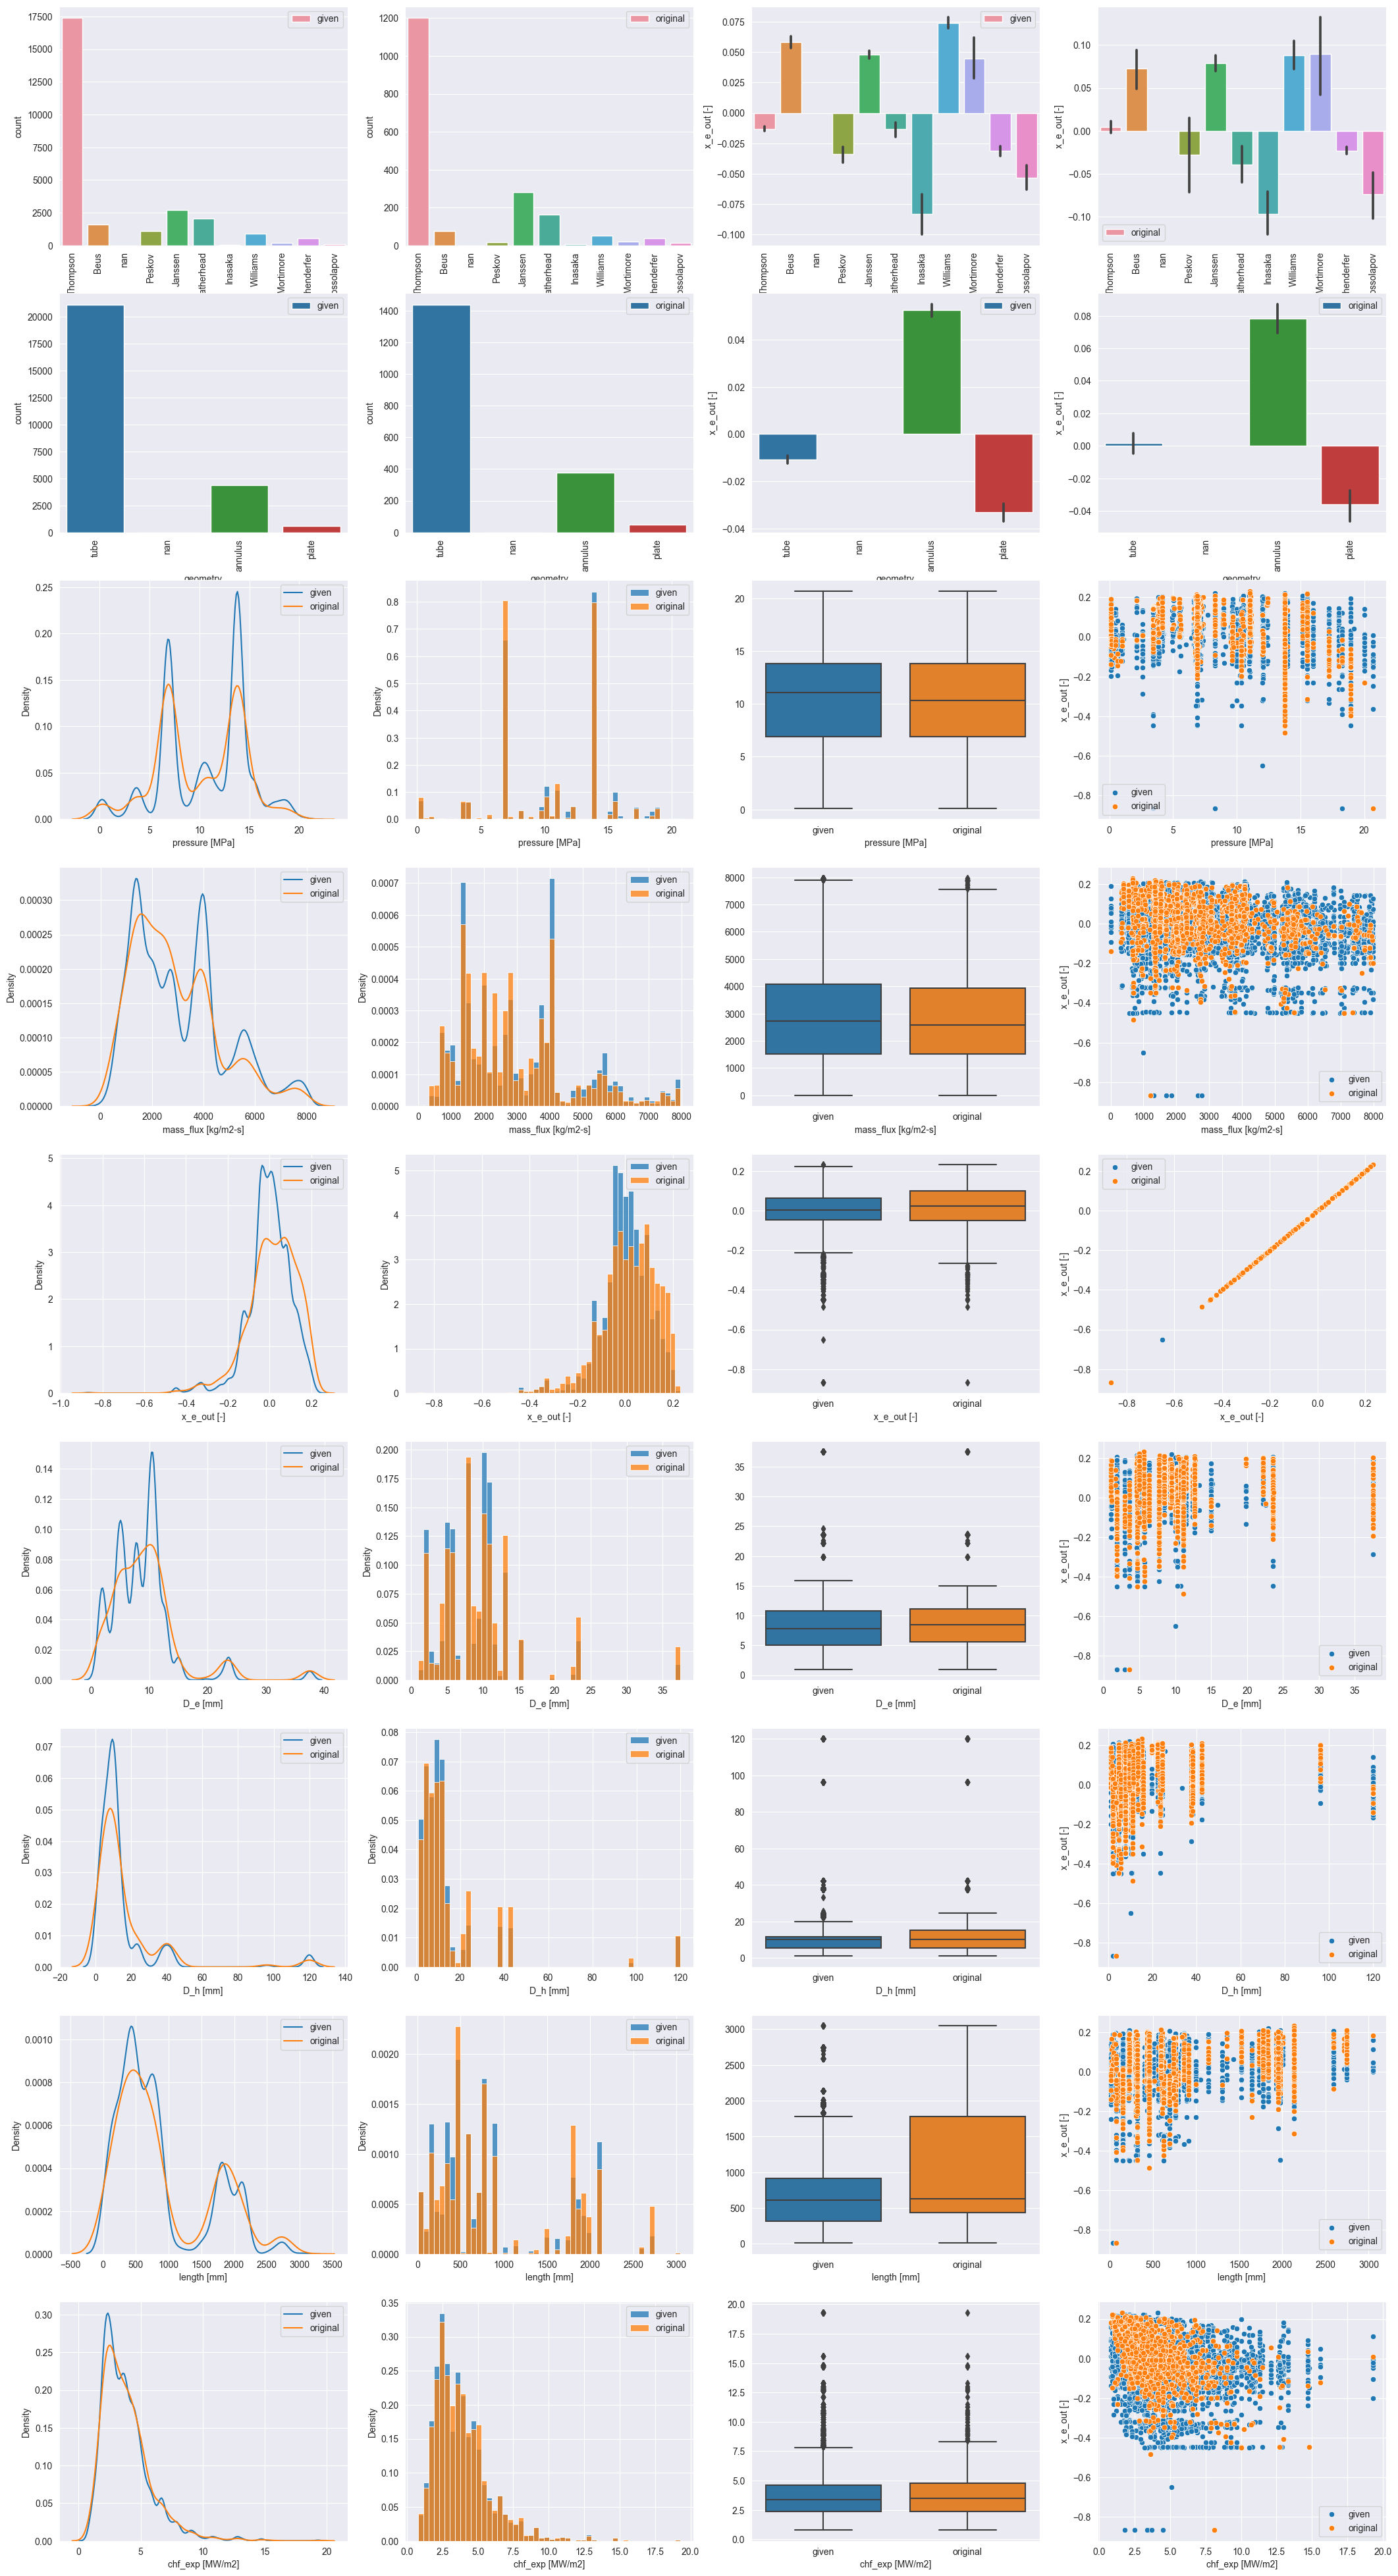

In [9]:
fig, axes = plt.subplots(nrows=len(df_data.columns), ncols=4, figsize=(26, 50))
axes = axes.flatten()

def graph_numerical_feature(data: list[tuple[pd.DataFrame, str, str]], target: str, axes_start_i: int) -> None:
    # Plot densities
    for df, column, label in data:
        sns.kdeplot(df[column], label=label, ax=axes[axes_start_i], fill=False)
    for df, column, label in data:
        sns.histplot(df[column], label=label, ax=axes[axes_start_i + 1], stat="density", bins=50)

    # Plot boxplot
    tmp_data_dict = {}
    for df, column, label in data:
        tmp_data_dict[label] = df[column]
    df_tmp = pd.DataFrame(tmp_data_dict)
    sns.boxplot(data=df_tmp, ax=axes[axes_start_i + 2])
    axes[axes_start_i + 2].set_xlabel(col)

    # Plot target correlation
    for df, column, label in data:
        sns.scatterplot(x=column, y=target, label=label, ax=axes[axes_start_i + 3], data=df)

    # Plot legends
    axes[axes_start_i].legend()
    axes[axes_start_i + 1].legend()
    axes[axes_start_i + 3].legend()

def graph_categorical_feature(data: list[tuple[pd.DataFrame, str, str]], target: str, axes_start_i: int) -> None:
    # Makes sure that the categories are shown in the same order
    category_order: list[str] = data[0][0][data[0][1]].unique()

    # Plot barplots
    for il, data_pack in enumerate(data):
        df, column, label = data_pack
        sns.countplot(x=column, data=df, label=label, order=category_order, ax=axes[axes_start_i + il])
        axes[axes_start_i + il].tick_params(axis='x', rotation=90)  # Rotate x-axis labels

    # Plot target correlation
    for il, data_pack in enumerate(data):
        df, column, label = data_pack
        sns.barplot(x=column, y=target, data=df, label=label, order=category_order, ax=axes[axes_start_i + 2 + il])
        axes[axes_start_i + 2 + il].tick_params(axis='x', rotation=90)  # Rotate x-axis labels

    # Plot legends
    axes[axes_start_i].legend()
    axes[axes_start_i + 1].legend()
    axes[axes_start_i + 2].legend()
    axes[axes_start_i + 3].legend()


i = 0
for col in df_data.columns:
    if pd.api.types.is_numeric_dtype(df_data[col]):
        graph_numerical_feature([(df_data, col, 'given'), (df_og, col, 'original')], 'x_e_out [-]', i)
    else:
        graph_categorical_feature([(df_data, col, 'given'), (df_og, col, 'original')], 'x_e_out [-]', i)
    i += 4

plt.show()

##### The original data closely follows the distribution of our given synthetic data. This suggesting the value where nulled in our given data set evenly across all features, this means that original data should be good to use without introduction feature or distribution bias.

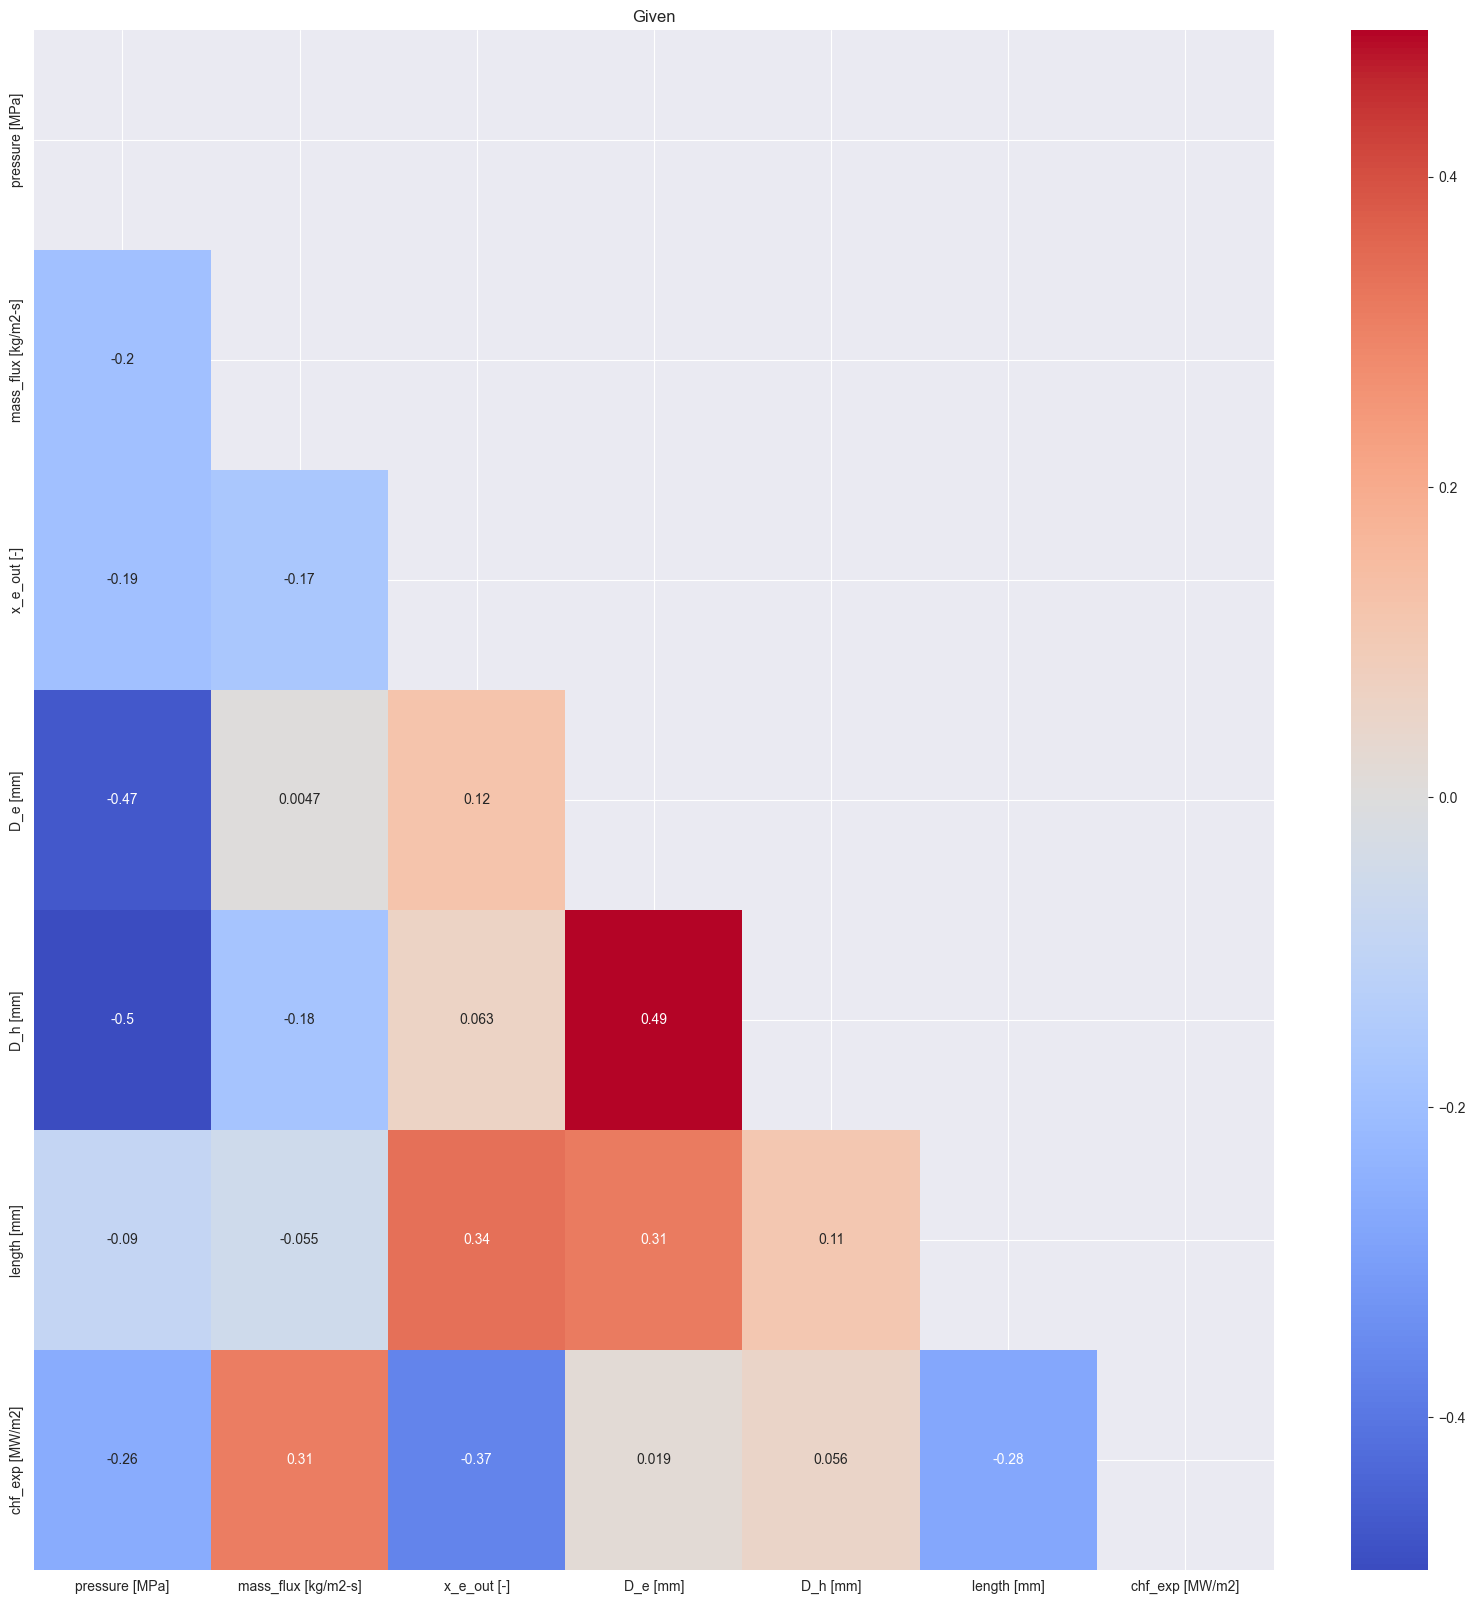

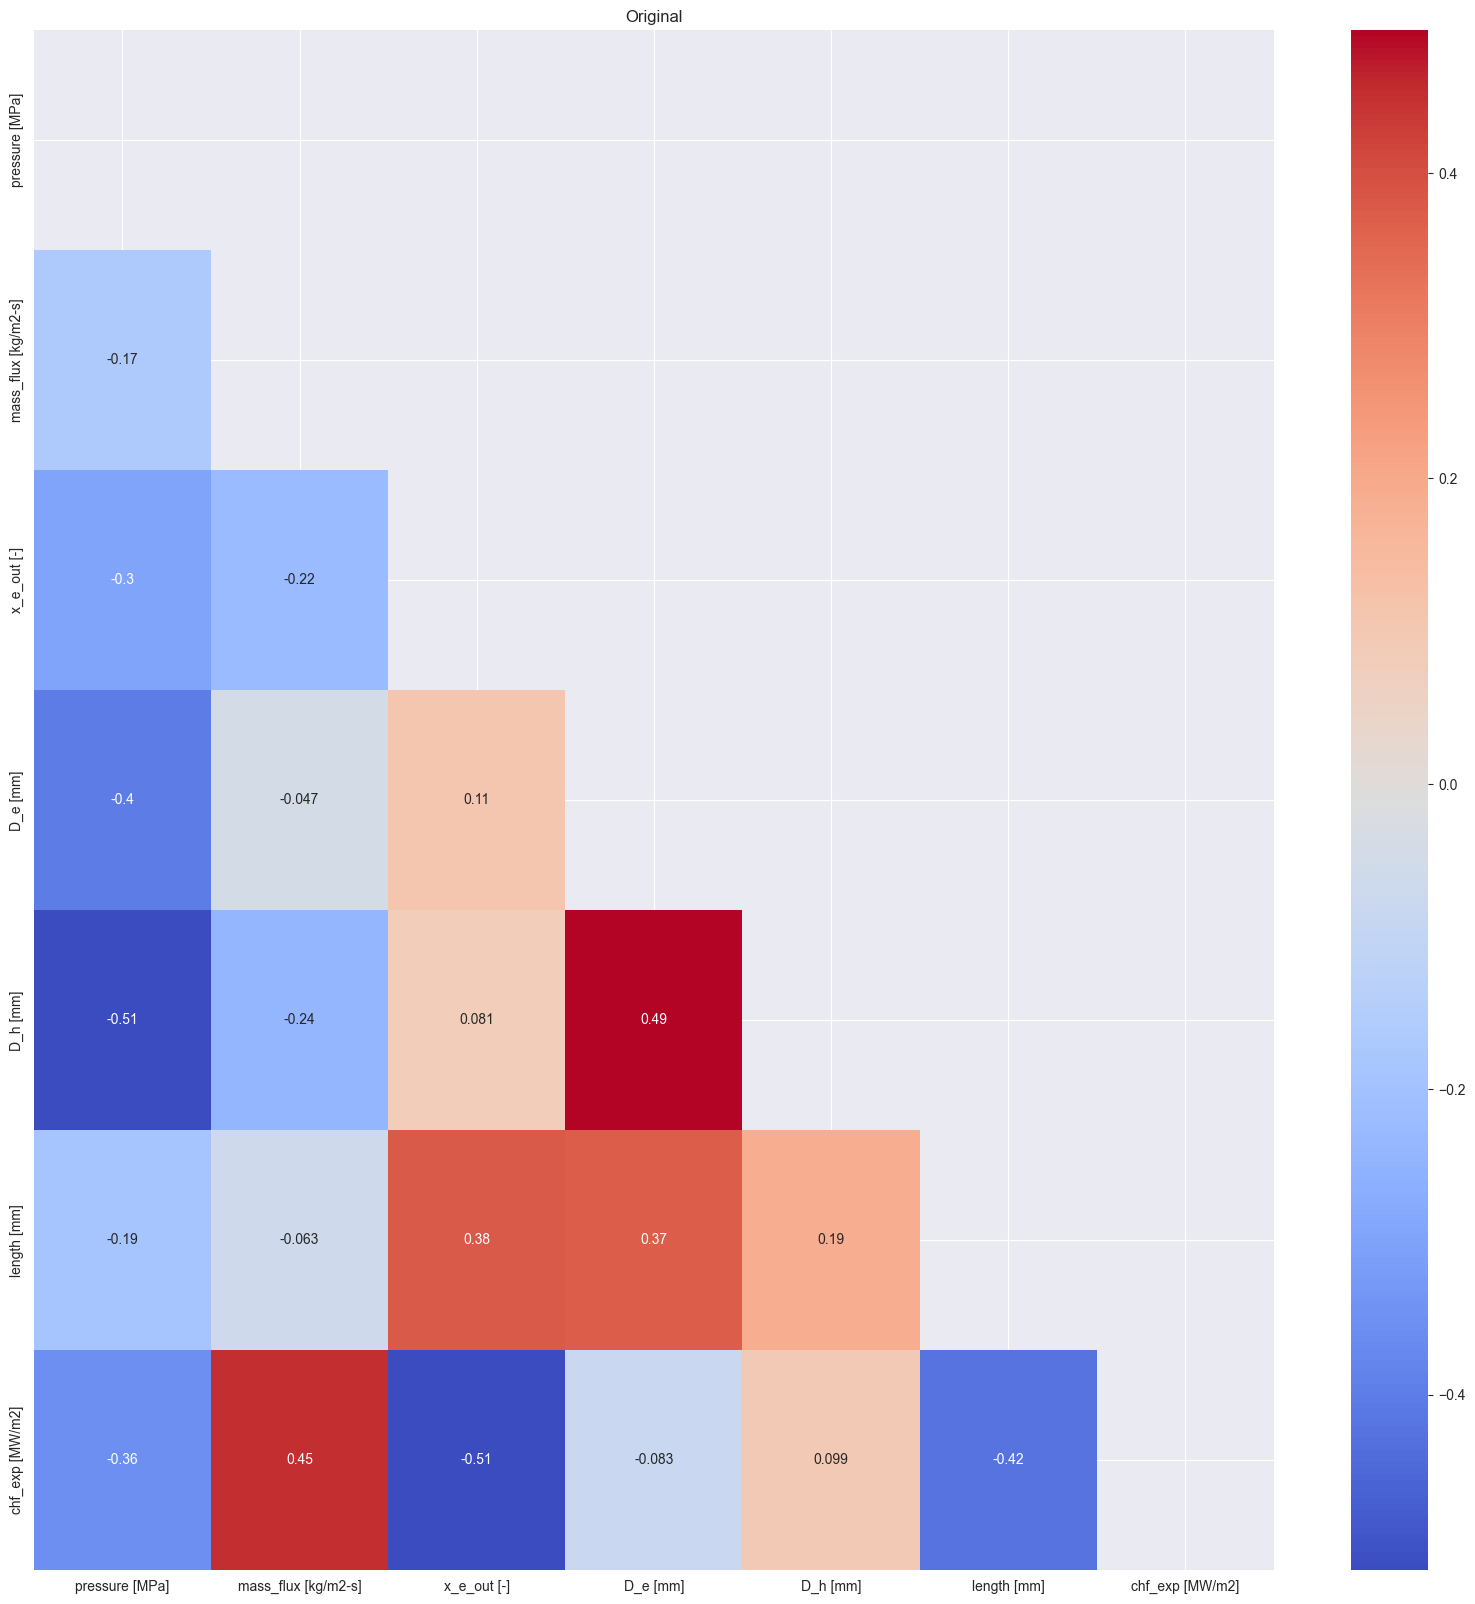

In [10]:
def show_feature_correlation(df: pd.DataFrame, title: str):
    plt.figure(figsize=(20, 20))
    corr_matrix = df.select_dtypes(include='number').corr()

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr_matrix, dtype=bool)
    mask[np.triu_indices_from(mask)] = True

    sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, mask=mask)
    plt.title(title)
    plt.show()

show_feature_correlation(df_data, "Given")
show_feature_correlation(df_og, "Original")

# Data Prep

In [11]:
numerical_columns = ['pressure [MPa]', 'mass_flux [kg/m2-s]','x_e_out [-]', 'D_e [mm]', 'D_h [mm]', 'length [mm]', 'chf_exp [MW/m2]']
numerical_features = ['pressure [MPa]', 'mass_flux [kg/m2-s]', 'D_e [mm]', 'D_h [mm]', 'length [mm]', 'chf_exp [MW/m2]']
categorical_columns = ['author', 'geometry']
target = 'x_e_out [-]'

In [12]:
label_encoders = {}

def label_encode(df: pd.DataFrame) -> None:
    for column in categorical_columns:
        label_encoder: LabelEncoder = LabelEncoder()
        df[column] = label_encoder.fit_transform(df[column])
        label_encoders[column] = label_encoder

def reverse_encode(df: pd.DataFrame) -> None:
    for column in label_encoders.keys():
        df[column] = df[column].astype(int)
        df[column] = label_encoders[column].inverse_transform(df[column])

In [13]:
df_train: pd.DataFrame = pd.concat([df_data, df_og])

In [14]:
label_encode(df_train)

# Train

## Baseline 0: Impute all missing numerical value including target using MICE

In [15]:
# Create an instance of imputer
imputer = IterativeSVD()
#imputer = KNN()

# Perform the imputation
df_train_imputed = pd.DataFrame(imputer.fit_transform(df_train), columns=df_train.columns)
# Print the imputed DataFrame
print("Imputed DataFrame:")
df_train_imputed

[IterativeSVD] Iter 1: observed MAE=78.775477
[IterativeSVD] Iter 2: observed MAE=2.943732
[IterativeSVD] Iter 3: observed MAE=1.032400
[IterativeSVD] Iter 4: observed MAE=0.005884
Imputed DataFrame:


,author,geometry,pressure [MPa],mass_flux [kg/m2-s],x_e_out [-],D_e [mm],D_h [mm],length [mm],chf_exp [MW/m2]
0,7.0,2.0,7.000000,3770.0,0.175400,6.705786,10.8,432.0,3.6
1,7.0,2.0,12.354828,6049.0,-0.041600,10.300000,10.3,762.0,6.2
2,7.0,3.0,13.790000,2034.0,0.033500,7.700000,7.7,457.0,2.5
3,0.0,0.0,13.790000,3679.0,-0.027900,5.600000,15.2,2134.0,3.0
4,10.0,2.0,13.790000,686.0,0.001665,11.100000,11.1,457.0,2.8
...,...,...,...,...,...,...,...,...,...
33504,6.0,1.0,1.010000,1500.0,-0.021800,15.000000,120.0,10.0,9.4
33505,6.0,1.0,1.010000,1500.0,-0.043400,15.000000,120.0,10.0,10.4
33506,6.0,1.0,1.010000,2000.0,-0.010900,15.000000,120.0,10.0,10.8
33507,6.0,1.0,1.010000,2000.0,-0.021800,15.000000,120.0,10.0,10.9


In [16]:
df_train_imputed.isna().sum()

author                 0
geometry               0
pressure [MPa]         0
mass_flux [kg/m2-s]    0
x_e_out [-]            0
D_e [mm]               0
D_h [mm]               0
length [mm]            0
chf_exp [MW/m2]        0
dtype: int64

## Baseline 1: Tree boosting on imputed data

### Construct new training data

In [17]:
for column in numerical_features:
    if df_train[column].isna().sum() > 0:
        df_train[f'{column}_was_an'] = df_train[column].isna().astype(int)

In [18]:
for column in numerical_features:
    if df_train[column].isna().sum() > 0:
        df_train[column] = df_train_imputed[column]

In [19]:
df_test = df_train[df_train[target].isna()]
df_train = df_train[~df_train[target].isna()]

In [20]:
import re
def remove_special_characters(column_name):
    # Remove special characters using regular expressions
    return re.sub(r"[^a-zA-Z0-9_]+", "", column_name)

def remove_special_characters_from_dataframe(df):
    # Remove special characters from all column names in the DataFrame
    df.columns = [remove_special_characters(col) for col in df.columns]
    return df

df_test = remove_special_characters_from_dataframe(df_test)
df_train = remove_special_characters_from_dataframe(df_train)

In [39]:
import optuna
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

def objective(trial):
    # Define the hyperparameter search space
    params = {
        'objective': 'regression',
        'metric': 'mae',
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 10, 100),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.1, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.1, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 20),
        'lambda_l1': trial.suggest_float('lambda_l1', 0.01, 10.0),
        'lambda_l2': trial.suggest_float('lambda_l2', 0.01, 10.0),
        'verbosity': -1
    }

    # Split the data into training and validation sets
    X = df_train.drop('x_e_out', axis=1)
    y = df_train['x_e_out']
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train the LGBM regressor
    model = lgb.LGBMRegressor(**params)
    model.fit(X_train, y_train)

    # Predict on the validation set and calculate MAE
    y_pred = model.predict(X_val)
    mae = mean_absolute_error(y_val, y_pred)

    return mae

# Create the Optuna study
study = optuna.create_study(direction='minimize')

# Start the hyperparameter search
study.optimize(objective, n_trials=200)

# Print the best parameters and the best MAE
best_params = study.best_params
best_mae = study.best_value
print(f"Best Parameters: {best_params}")
print(f"Best MAE: {best_mae}")

[I 2023-05-16 18:52:53,600] A new study created in memory with name: no-name-023d2eef-8b0b-4790-811a-5d119cd70c07
[I 2023-05-16 18:52:53,770] Trial 0 finished with value: 0.058823416745286815 and parameters: {'num_leaves': 80, 'learning_rate': 0.0652093952654761, 'feature_fraction': 0.7340656513403339, 'bagging_fraction': 0.21752902209307745, 'bagging_freq': 1, 'min_child_samples': 9, 'lambda_l1': 8.312765045955599, 'lambda_l2': 6.8578224668247705}. Best is trial 0 with value: 0.058823416745286815.


[LightGBM] [Warning] feature_fraction is set=0.7340656513403339, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7340656513403339
[LightGBM] [Warning] lambda_l1 is set=8.312765045955599, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.312765045955599
[LightGBM] [Warning] bagging_fraction is set=0.21752902209307745, subsample=1.0 will be ignored. Current value: bagging_fraction=0.21752902209307745
[LightGBM] [Warning] lambda_l2 is set=6.8578224668247705, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.8578224668247705
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6518734673861895, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6518734673861895
[LightGBM] [Warning] lambda_l1 is set=8.693633198335611, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.693633198335611
[LightGBM] [Warning] bagging_fraction i

[I 2023-05-16 18:52:53,905] Trial 1 finished with value: 0.05871776765917372 and parameters: {'num_leaves': 70, 'learning_rate': 0.09965823397220294, 'feature_fraction': 0.6518734673861895, 'bagging_fraction': 0.2468837711893927, 'bagging_freq': 10, 'min_child_samples': 7, 'lambda_l1': 8.693633198335611, 'lambda_l2': 0.8251453746016929}. Best is trial 1 with value: 0.05871776765917372.
[I 2023-05-16 18:52:54,040] Trial 2 finished with value: 0.058344407283583775 and parameters: {'num_leaves': 55, 'learning_rate': 0.08659204981525404, 'feature_fraction': 0.7879910755499001, 'bagging_fraction': 0.20132108623726952, 'bagging_freq': 3, 'min_child_samples': 1, 'lambda_l1': 7.16645517477317, 'lambda_l2': 0.2987723055710924}. Best is trial 2 with value: 0.058344407283583775.


[LightGBM] [Warning] feature_fraction is set=0.7879910755499001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7879910755499001
[LightGBM] [Warning] lambda_l1 is set=7.16645517477317, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.16645517477317
[LightGBM] [Warning] bagging_fraction is set=0.20132108623726952, subsample=1.0 will be ignored. Current value: bagging_fraction=0.20132108623726952
[LightGBM] [Warning] lambda_l2 is set=0.2987723055710924, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2987723055710924
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.5679879322399645, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5679879322399645
[LightGBM] [Warning] lambda_l1 is set=3.069297800256888, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.069297800256888
[LightGBM] [Warning] bagging_fraction is 

[I 2023-05-16 18:52:54,280] Trial 3 finished with value: 0.0552754005157147 and parameters: {'num_leaves': 94, 'learning_rate': 0.04529514532094605, 'feature_fraction': 0.5679879322399645, 'bagging_fraction': 0.6601599632954229, 'bagging_freq': 4, 'min_child_samples': 13, 'lambda_l1': 3.069297800256888, 'lambda_l2': 8.908556629491962}. Best is trial 3 with value: 0.0552754005157147.


[LightGBM] [Warning] feature_fraction is set=0.9050153505516689, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9050153505516689
[LightGBM] [Warning] lambda_l1 is set=0.5323292398003087, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5323292398003087
[LightGBM] [Warning] bagging_fraction is set=0.5460781783222557, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5460781783222557
[LightGBM] [Warning] lambda_l2 is set=8.398345105470355, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.398345105470355
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2023-05-16 18:52:54,676] Trial 4 finished with value: 0.05588455543171483 and parameters: {'num_leaves': 78, 'learning_rate': 0.015860282569866376, 'feature_fraction': 0.9050153505516689, 'bagging_fraction': 0.5460781783222557, 'bagging_freq': 8, 'min_child_samples': 13, 'lambda_l1': 0.5323292398003087, 'lambda_l2': 8.398345105470355}. Best is trial 3 with value: 0.0552754005157147.
[I 2023-05-16 18:52:54,844] Trial 5 finished with value: 0.055495961370924614 and parameters: {'num_leaves': 97, 'learning_rate': 0.06291457328319844, 'feature_fraction': 0.49070150623016906, 'bagging_fraction': 0.17254272045136987, 'bagging_freq': 3, 'min_child_samples': 3, 'lambda_l1': 1.3925598627423563, 'lambda_l2': 7.419077130726412}. Best is trial 3 with value: 0.0552754005157147.


[LightGBM] [Warning] feature_fraction is set=0.49070150623016906, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49070150623016906
[LightGBM] [Warning] lambda_l1 is set=1.3925598627423563, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3925598627423563
[LightGBM] [Warning] bagging_fraction is set=0.17254272045136987, subsample=1.0 will be ignored. Current value: bagging_fraction=0.17254272045136987
[LightGBM] [Warning] lambda_l2 is set=7.419077130726412, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.419077130726412
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.941176623097827, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.941176623097827
[LightGBM] [Warning] lambda_l1 is set=9.7019801423574, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.7019801423574
[LightGBM] [Warning] bagging_fraction is se

[I 2023-05-16 18:52:54,900] Trial 6 finished with value: 0.06012208353013459 and parameters: {'num_leaves': 96, 'learning_rate': 0.09776084365326929, 'feature_fraction': 0.941176623097827, 'bagging_fraction': 0.13655207900157854, 'bagging_freq': 7, 'min_child_samples': 13, 'lambda_l1': 9.7019801423574, 'lambda_l2': 9.531310971595088}. Best is trial 3 with value: 0.0552754005157147.
[I 2023-05-16 18:52:54,963] Trial 7 finished with value: 0.06115240202775556 and parameters: {'num_leaves': 38, 'learning_rate': 0.0831509969010718, 'feature_fraction': 0.10290560127358857, 'bagging_fraction': 0.5861276964795699, 'bagging_freq': 6, 'min_child_samples': 8, 'lambda_l1': 9.261278225594147, 'lambda_l2': 8.715527164511538}. Best is trial 3 with value: 0.0552754005157147.
[I 2023-05-16 18:52:55,077] Trial 8 finished with value: 0.05835994275962947 and parameters: {'num_leaves': 73, 'learning_rate': 0.050992289024854205, 'feature_fraction': 0.5703966726761817, 'bagging_fraction': 0.2918833995685876

[LightGBM] [Warning] feature_fraction is set=0.10290560127358857, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10290560127358857
[LightGBM] [Warning] lambda_l1 is set=9.261278225594147, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.261278225594147
[LightGBM] [Warning] bagging_fraction is set=0.5861276964795699, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5861276964795699
[LightGBM] [Warning] lambda_l2 is set=8.715527164511538, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.715527164511538
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5703966726761817, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5703966726761817
[LightGBM] [Warning] lambda_l1 is set=7.260896169357297, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.260896169357297
[LightGBM] [Warning] bagging_fraction is 

[I 2023-05-16 18:52:55,216] Trial 9 finished with value: 0.056690888365282556 and parameters: {'num_leaves': 23, 'learning_rate': 0.05267866064632924, 'feature_fraction': 0.4200937770550125, 'bagging_fraction': 0.885175481882255, 'bagging_freq': 4, 'min_child_samples': 19, 'lambda_l1': 8.461210597104118, 'lambda_l2': 4.735316789272955}. Best is trial 3 with value: 0.0552754005157147.
[I 2023-05-16 18:52:55,357] Trial 10 finished with value: 0.05738168126369182 and parameters: {'num_leaves': 11, 'learning_rate': 0.031080648717682183, 'feature_fraction': 0.36727641022805857, 'bagging_fraction': 0.9543376549691704, 'bagging_freq': 1, 'min_child_samples': 20, 'lambda_l1': 3.4223007643523653, 'lambda_l2': 9.627832719659372}. Best is trial 3 with value: 0.0552754005157147.


[LightGBM] [Warning] feature_fraction is set=0.36727641022805857, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.36727641022805857
[LightGBM] [Warning] lambda_l1 is set=3.4223007643523653, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4223007643523653
[LightGBM] [Warning] bagging_fraction is set=0.9543376549691704, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9543376549691704
[LightGBM] [Warning] lambda_l2 is set=9.627832719659372, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.627832719659372
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.466954745551294, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.466954745551294
[LightGBM] [Warning] lambda_l1 is set=2.2472781994014555, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2472781994014555
[LightGBM] [Warning] bagging_fraction i

[I 2023-05-16 18:52:55,567] Trial 11 finished with value: 0.05590999394784887 and parameters: {'num_leaves': 100, 'learning_rate': 0.036069409539076315, 'feature_fraction': 0.466954745551294, 'bagging_fraction': 0.45837516674502177, 'bagging_freq': 4, 'min_child_samples': 15, 'lambda_l1': 2.2472781994014555, 'lambda_l2': 7.1387007328535494}. Best is trial 3 with value: 0.0552754005157147.
[I 2023-05-16 18:52:55,804] Trial 12 finished with value: 0.055102062266206196 and parameters: {'num_leaves': 90, 'learning_rate': 0.06510145356578517, 'feature_fraction': 0.5522535671874009, 'bagging_fraction': 0.7268027288485407, 'bagging_freq': 3, 'min_child_samples': 1, 'lambda_l1': 4.25764306479205, 'lambda_l2': 7.068179488150896}. Best is trial 12 with value: 0.055102062266206196.


[LightGBM] [Warning] feature_fraction is set=0.5522535671874009, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5522535671874009
[LightGBM] [Warning] lambda_l1 is set=4.25764306479205, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.25764306479205
[LightGBM] [Warning] bagging_fraction is set=0.7268027288485407, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7268027288485407
[LightGBM] [Warning] lambda_l2 is set=7.068179488150896, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.068179488150896
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-05-16 18:52:56,008] Trial 13 finished with value: 0.05493136478325558 and parameters: {'num_leaves': 55, 'learning_rate': 0.0698622468270835, 'feature_fraction': 0.6125973629772548, 'bagging_fraction': 0.76407315518066, 'bagging_freq': 3, 'min_child_samples': 16, 'lambda_l1': 4.474025170653077, 'lambda_l2': 6.398003291170723}. Best is trial 13 with value: 0.05493136478325558.


[LightGBM] [Warning] feature_fraction is set=0.6125973629772548, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6125973629772548
[LightGBM] [Warning] lambda_l1 is set=4.474025170653077, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.474025170653077
[LightGBM] [Warning] bagging_fraction is set=0.76407315518066, subsample=1.0 will be ignored. Current value: bagging_fraction=0.76407315518066
[LightGBM] [Warning] lambda_l2 is set=6.398003291170723, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.398003291170723
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.6938027021519961, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6938027021519961
[LightGBM] [Warning] lambda_l1 is set=4.939519157098188, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.939519157098188
[LightGBM] [Warning] bagging_fraction is set=0.

[I 2023-05-16 18:52:56,198] Trial 14 finished with value: 0.05489516444444023 and parameters: {'num_leaves': 54, 'learning_rate': 0.0727770635168177, 'feature_fraction': 0.6938027021519961, 'bagging_fraction': 0.763452994738151, 'bagging_freq': 2, 'min_child_samples': 16, 'lambda_l1': 4.939519157098188, 'lambda_l2': 5.975275404390685}. Best is trial 14 with value: 0.05489516444444023.
[I 2023-05-16 18:52:56,408] Trial 15 finished with value: 0.05505522119660371 and parameters: {'num_leaves': 53, 'learning_rate': 0.07515347379872195, 'feature_fraction': 0.7733064451967555, 'bagging_fraction': 0.8089924944373492, 'bagging_freq': 2, 'min_child_samples': 16, 'lambda_l1': 5.718857405343683, 'lambda_l2': 5.683610350522311}. Best is trial 14 with value: 0.05489516444444023.


[LightGBM] [Warning] feature_fraction is set=0.7733064451967555, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7733064451967555
[LightGBM] [Warning] lambda_l1 is set=5.718857405343683, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.718857405343683
[LightGBM] [Warning] bagging_fraction is set=0.8089924944373492, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8089924944373492
[LightGBM] [Warning] lambda_l2 is set=5.683610350522311, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.683610350522311
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-05-16 18:52:56,587] Trial 16 finished with value: 0.054846490043251185 and parameters: {'num_leaves': 44, 'learning_rate': 0.07966187434340134, 'feature_fraction': 0.7060826311346128, 'bagging_fraction': 0.7798501038266399, 'bagging_freq': 2, 'min_child_samples': 17, 'lambda_l1': 5.048313728705221, 'lambda_l2': 3.497000413679295}. Best is trial 16 with value: 0.054846490043251185.


[LightGBM] [Warning] feature_fraction is set=0.7060826311346128, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7060826311346128
[LightGBM] [Warning] lambda_l1 is set=5.048313728705221, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.048313728705221
[LightGBM] [Warning] bagging_fraction is set=0.7798501038266399, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7798501038266399
[LightGBM] [Warning] lambda_l2 is set=3.497000413679295, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.497000413679295
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8695767034415012, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8695767034415012
[LightGBM] [Warning] lambda_l1 is set=5.704688852528822, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.704688852528822
[LightGBM] [Warning] bagging_fraction is se

[I 2023-05-16 18:52:56,783] Trial 17 finished with value: 0.0547715269366385 and parameters: {'num_leaves': 40, 'learning_rate': 0.08406024711447077, 'feature_fraction': 0.8695767034415012, 'bagging_fraction': 0.9816909871929596, 'bagging_freq': 1, 'min_child_samples': 18, 'lambda_l1': 5.704688852528822, 'lambda_l2': 3.7317443159116}. Best is trial 17 with value: 0.0547715269366385.
[I 2023-05-16 18:52:56,978] Trial 18 finished with value: 0.054813477667406164 and parameters: {'num_leaves': 37, 'learning_rate': 0.08545726547289414, 'feature_fraction': 0.8703794212365403, 'bagging_fraction': 0.9586457565656447, 'bagging_freq': 1, 'min_child_samples': 18, 'lambda_l1': 5.964435280588207, 'lambda_l2': 3.4796467215643947}. Best is trial 17 with value: 0.0547715269366385.


[LightGBM] [Warning] feature_fraction is set=0.8703794212365403, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8703794212365403
[LightGBM] [Warning] lambda_l1 is set=5.964435280588207, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.964435280588207
[LightGBM] [Warning] bagging_fraction is set=0.9586457565656447, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9586457565656447
[LightGBM] [Warning] lambda_l2 is set=3.4796467215643947, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.4796467215643947
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9808145312449994, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9808145312449994
[LightGBM] [Warning] lambda_l1 is set=6.317197175655472, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.317197175655472
[LightGBM] [Warning] bagging_fraction is 

[I 2023-05-16 18:52:57,168] Trial 19 finished with value: 0.05479310083461224 and parameters: {'num_leaves': 31, 'learning_rate': 0.08614873357622346, 'feature_fraction': 0.9808145312449994, 'bagging_fraction': 0.9821833967851796, 'bagging_freq': 1, 'min_child_samples': 18, 'lambda_l1': 6.317197175655472, 'lambda_l2': 3.140126022640735}. Best is trial 17 with value: 0.0547715269366385.
[I 2023-05-16 18:52:57,366] Trial 20 finished with value: 0.05494525351399231 and parameters: {'num_leaves': 25, 'learning_rate': 0.09153615661519793, 'feature_fraction': 0.9965269128510242, 'bagging_fraction': 0.9845136303391314, 'bagging_freq': 9, 'min_child_samples': 20, 'lambda_l1': 6.685283940365829, 'lambda_l2': 2.0769139490727393}. Best is trial 17 with value: 0.0547715269366385.


[LightGBM] [Warning] feature_fraction is set=0.9965269128510242, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9965269128510242
[LightGBM] [Warning] lambda_l1 is set=6.685283940365829, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.685283940365829
[LightGBM] [Warning] bagging_fraction is set=0.9845136303391314, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9845136303391314
[LightGBM] [Warning] lambda_l2 is set=2.0769139490727393, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0769139490727393
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] feature_fraction is set=0.8586217746633644, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8586217746633644
[LightGBM] [Warning] lambda_l1 is set=6.054581239559539, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.054581239559539
[LightGBM] [Warning] bagging_fraction is 

[I 2023-05-16 18:52:57,551] Trial 21 finished with value: 0.05482953981806051 and parameters: {'num_leaves': 33, 'learning_rate': 0.09052962494830008, 'feature_fraction': 0.8586217746633644, 'bagging_fraction': 0.9053878483106462, 'bagging_freq': 1, 'min_child_samples': 19, 'lambda_l1': 6.054581239559539, 'lambda_l2': 3.467793797730469}. Best is trial 17 with value: 0.0547715269366385.
[I 2023-05-16 18:52:57,770] Trial 22 finished with value: 0.054812997327700105 and parameters: {'num_leaves': 26, 'learning_rate': 0.08027844051074857, 'feature_fraction': 0.9977765567538236, 'bagging_fraction': 0.9950165028638202, 'bagging_freq': 1, 'min_child_samples': 18, 'lambda_l1': 6.016850505043206, 'lambda_l2': 3.134611316892531}. Best is trial 17 with value: 0.0547715269366385.


[LightGBM] [Warning] feature_fraction is set=0.9977765567538236, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9977765567538236
[LightGBM] [Warning] lambda_l1 is set=6.016850505043206, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.016850505043206
[LightGBM] [Warning] bagging_fraction is set=0.9950165028638202, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9950165028638202
[LightGBM] [Warning] lambda_l2 is set=3.134611316892531, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.134611316892531
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-05-16 18:52:57,955] Trial 23 finished with value: 0.05563802053726426 and parameters: {'num_leaves': 13, 'learning_rate': 0.07821922855714089, 'feature_fraction': 0.9915303095108198, 'bagging_fraction': 0.9997371157175637, 'bagging_freq': 2, 'min_child_samples': 11, 'lambda_l1': 7.578537742307049, 'lambda_l2': 2.4452164318576646}. Best is trial 17 with value: 0.0547715269366385.


[LightGBM] [Warning] feature_fraction is set=0.9915303095108198, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9915303095108198
[LightGBM] [Warning] lambda_l1 is set=7.578537742307049, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.578537742307049
[LightGBM] [Warning] bagging_fraction is set=0.9997371157175637, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9997371157175637
[LightGBM] [Warning] lambda_l2 is set=2.4452164318576646, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4452164318576646
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8360573896878574, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8360573896878574
[LightGBM] [Warning] lambda_l1 is set=6.168875659348983, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.168875659348983
[LightGBM] [Warning] bagging_fraction is 

[I 2023-05-16 18:52:58,156] Trial 24 finished with value: 0.054930956990021915 and parameters: {'num_leaves': 25, 'learning_rate': 0.09310383238742061, 'feature_fraction': 0.8360573896878574, 'bagging_fraction': 0.8922543085016148, 'bagging_freq': 1, 'min_child_samples': 14, 'lambda_l1': 6.168875659348983, 'lambda_l2': 4.248546277623958}. Best is trial 17 with value: 0.0547715269366385.


[LightGBM] [Warning] feature_fraction is set=0.9353081871203858, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9353081871203858
[LightGBM] [Warning] lambda_l1 is set=6.635935235846301, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.635935235846301
[LightGBM] [Warning] bagging_fraction is set=0.8507038960719501, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8507038960719501
[LightGBM] [Warning] lambda_l2 is set=2.480052136016902, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.480052136016902
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-05-16 18:52:58,417] Trial 25 finished with value: 0.055030140259199625 and parameters: {'num_leaves': 43, 'learning_rate': 0.08101752692213741, 'feature_fraction': 0.9353081871203858, 'bagging_fraction': 0.8507038960719501, 'bagging_freq': 5, 'min_child_samples': 17, 'lambda_l1': 6.635935235846301, 'lambda_l2': 2.480052136016902}. Best is trial 17 with value: 0.0547715269366385.
[I 2023-05-16 18:52:58,607] Trial 26 finished with value: 0.055229444750042544 and parameters: {'num_leaves': 17, 'learning_rate': 0.07327712445563896, 'feature_fraction': 0.9875686405708225, 'bagging_fraction': 0.8493058618532383, 'bagging_freq': 2, 'min_child_samples': 11, 'lambda_l1': 5.350635344524905, 'lambda_l2': 4.16882273870344}. Best is trial 17 with value: 0.0547715269366385.


[LightGBM] [Warning] feature_fraction is set=0.9875686405708225, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9875686405708225
[LightGBM] [Warning] lambda_l1 is set=5.350635344524905, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.350635344524905
[LightGBM] [Warning] bagging_fraction is set=0.8493058618532383, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8493058618532383
[LightGBM] [Warning] lambda_l2 is set=4.16882273870344, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.16882273870344
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.896599373931449, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.896599373931449
[LightGBM] [Warning] lambda_l1 is set=7.647865536671784, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.647865536671784
[LightGBM] [Warning] bagging_fraction is set=0.

[I 2023-05-16 18:52:58,864] Trial 27 finished with value: 0.05515468367630276 and parameters: {'num_leaves': 30, 'learning_rate': 0.08540910781450901, 'feature_fraction': 0.896599373931449, 'bagging_fraction': 0.92904922746384, 'bagging_freq': 5, 'min_child_samples': 18, 'lambda_l1': 7.647865536671784, 'lambda_l2': 1.7191050866967905}. Best is trial 17 with value: 0.0547715269366385.
[I 2023-05-16 18:52:59,092] Trial 28 finished with value: 0.054823522161656285 and parameters: {'num_leaves': 47, 'learning_rate': 0.09326811081197063, 'feature_fraction': 0.79982120035796, 'bagging_fraction': 0.9983013022689646, 'bagging_freq': 1, 'min_child_samples': 18, 'lambda_l1': 6.450157604501758, 'lambda_l2': 2.925273351292698}. Best is trial 17 with value: 0.0547715269366385.


[LightGBM] [Warning] feature_fraction is set=0.79982120035796, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.79982120035796
[LightGBM] [Warning] lambda_l1 is set=6.450157604501758, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.450157604501758
[LightGBM] [Warning] bagging_fraction is set=0.9983013022689646, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9983013022689646
[LightGBM] [Warning] lambda_l2 is set=2.925273351292698, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.925273351292698
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-05-16 18:52:59,282] Trial 29 finished with value: 0.055400696832130704 and parameters: {'num_leaves': 19, 'learning_rate': 0.06165935169273358, 'feature_fraction': 0.8420947525038425, 'bagging_fraction': 0.8396212713797478, 'bagging_freq': 1, 'min_child_samples': 15, 'lambda_l1': 5.4929696552476885, 'lambda_l2': 1.203831077708468}. Best is trial 17 with value: 0.0547715269366385.


[LightGBM] [Warning] feature_fraction is set=0.8420947525038425, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8420947525038425
[LightGBM] [Warning] lambda_l1 is set=5.4929696552476885, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.4929696552476885
[LightGBM] [Warning] bagging_fraction is set=0.8396212713797478, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8396212713797478
[LightGBM] [Warning] lambda_l2 is set=1.203831077708468, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.203831077708468
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9371740081639232, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9371740081639232
[LightGBM] [Warning] lambda_l1 is set=7.767490343126941, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.767490343126941
[LightGBM] [Warning] bagging_fraction is 

[I 2023-05-16 18:52:59,537] Trial 30 finished with value: 0.05537669307261077 and parameters: {'num_leaves': 62, 'learning_rate': 0.0679005353539993, 'feature_fraction': 0.9371740081639232, 'bagging_fraction': 0.9158825595991982, 'bagging_freq': 2, 'min_child_samples': 20, 'lambda_l1': 7.767490343126941, 'lambda_l2': 1.6650835323560051}. Best is trial 17 with value: 0.0547715269366385.
[I 2023-05-16 18:52:59,747] Trial 31 finished with value: 0.054978846839830876 and parameters: {'num_leaves': 33, 'learning_rate': 0.08612392020622565, 'feature_fraction': 0.8773573002775666, 'bagging_fraction': 0.9463910274331603, 'bagging_freq': 1, 'min_child_samples': 18, 'lambda_l1': 6.1309569915333455, 'lambda_l2': 3.2476262298946197}. Best is trial 17 with value: 0.0547715269366385.


[LightGBM] [Warning] feature_fraction is set=0.8773573002775666, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8773573002775666
[LightGBM] [Warning] lambda_l1 is set=6.1309569915333455, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.1309569915333455
[LightGBM] [Warning] bagging_fraction is set=0.9463910274331603, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9463910274331603
[LightGBM] [Warning] lambda_l2 is set=3.2476262298946197, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.2476262298946197
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-05-16 18:52:59,957] Trial 32 finished with value: 0.055062634122257446 and parameters: {'num_leaves': 39, 'learning_rate': 0.07773255806332076, 'feature_fraction': 0.7393109462893378, 'bagging_fraction': 0.9454934606981864, 'bagging_freq': 1, 'min_child_samples': 17, 'lambda_l1': 6.81369899419472, 'lambda_l2': 3.907232232633667}. Best is trial 17 with value: 0.0547715269366385.


[LightGBM] [Warning] feature_fraction is set=0.7393109462893378, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7393109462893378
[LightGBM] [Warning] lambda_l1 is set=6.81369899419472, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.81369899419472
[LightGBM] [Warning] bagging_fraction is set=0.9454934606981864, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9454934606981864
[LightGBM] [Warning] lambda_l2 is set=3.907232232633667, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.907232232633667
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-05-16 18:53:00,188] Trial 33 finished with value: 0.054711952454921366 and parameters: {'num_leaves': 30, 'learning_rate': 0.09914936808444391, 'feature_fraction': 0.8317958073922062, 'bagging_fraction': 0.9955980583286392, 'bagging_freq': 3, 'min_child_samples': 19, 'lambda_l1': 5.837760370958035, 'lambda_l2': 2.8694518302276206}. Best is trial 33 with value: 0.054711952454921366.


[LightGBM] [Warning] feature_fraction is set=0.8317958073922062, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8317958073922062
[LightGBM] [Warning] lambda_l1 is set=5.837760370958035, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.837760370958035
[LightGBM] [Warning] bagging_fraction is set=0.9955980583286392, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9955980583286392
[LightGBM] [Warning] lambda_l2 is set=2.8694518302276206, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8694518302276206
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-05-16 18:53:00,392] Trial 34 finished with value: 0.055170058731593086 and parameters: {'num_leaves': 29, 'learning_rate': 0.09916495609735947, 'feature_fraction': 0.9506283837829086, 'bagging_fraction': 0.8760451420126755, 'bagging_freq': 3, 'min_child_samples': 6, 'lambda_l1': 8.041589330666179, 'lambda_l2': 2.490454349610387}. Best is trial 33 with value: 0.054711952454921366.


[LightGBM] [Warning] feature_fraction is set=0.9506283837829086, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9506283837829086
[LightGBM] [Warning] lambda_l1 is set=8.041589330666179, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.041589330666179
[LightGBM] [Warning] bagging_fraction is set=0.8760451420126755, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8760451420126755
[LightGBM] [Warning] lambda_l2 is set=2.490454349610387, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.490454349610387
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8159943093936569, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8159943093936569
[LightGBM] [Warning] lambda_l1 is set=7.065872270249151, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.065872270249151
[LightGBM] [Warning] bagging_fraction is se

[I 2023-05-16 18:53:00,590] Trial 35 finished with value: 0.05517441900848438 and parameters: {'num_leaves': 20, 'learning_rate': 0.08922433635392701, 'feature_fraction': 0.8159943093936569, 'bagging_fraction': 0.9987210153436009, 'bagging_freq': 2, 'min_child_samples': 19, 'lambda_l1': 7.065872270249151, 'lambda_l2': 2.89077334993721}. Best is trial 33 with value: 0.054711952454921366.
[I 2023-05-16 18:53:00,771] Trial 36 finished with value: 0.05468803476760399 and parameters: {'num_leaves': 28, 'learning_rate': 0.09682564119577769, 'feature_fraction': 0.8921138011416514, 'bagging_fraction': 0.9140548334432729, 'bagging_freq': 3, 'min_child_samples': 10, 'lambda_l1': 5.3692076203345875, 'lambda_l2': 0.8708029191481068}. Best is trial 36 with value: 0.05468803476760399.


[LightGBM] [Warning] feature_fraction is set=0.8921138011416514, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8921138011416514
[LightGBM] [Warning] lambda_l1 is set=5.3692076203345875, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.3692076203345875
[LightGBM] [Warning] bagging_fraction is set=0.9140548334432729, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9140548334432729
[LightGBM] [Warning] lambda_l2 is set=0.8708029191481068, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.8708029191481068
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.7873797061600142, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7873797061600142
[LightGBM] [Warning] lambda_l1 is set=4.737816315051951, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.737816315051951
[LightGBM] [Warning] bagging_fraction i

[I 2023-05-16 18:53:01,000] Trial 37 finished with value: 0.054524544579942935 and parameters: {'num_leaves': 48, 'learning_rate': 0.09901425290685796, 'feature_fraction': 0.7873797061600142, 'bagging_fraction': 0.8259828698831095, 'bagging_freq': 4, 'min_child_samples': 10, 'lambda_l1': 4.737816315051951, 'lambda_l2': 0.2955734737015283}. Best is trial 37 with value: 0.054524544579942935.
[I 2023-05-16 18:53:01,217] Trial 38 finished with value: 0.054488429565271806 and parameters: {'num_leaves': 62, 'learning_rate': 0.09729350721839126, 'feature_fraction': 0.7713699182737309, 'bagging_fraction': 0.8319524805235585, 'bagging_freq': 4, 'min_child_samples': 9, 'lambda_l1': 4.312753668710163, 'lambda_l2': 0.1231782009934006}. Best is trial 38 with value: 0.054488429565271806.


[LightGBM] [Warning] feature_fraction is set=0.7713699182737309, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7713699182737309
[LightGBM] [Warning] lambda_l1 is set=4.312753668710163, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.312753668710163
[LightGBM] [Warning] bagging_fraction is set=0.8319524805235585, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8319524805235585
[LightGBM] [Warning] lambda_l2 is set=0.1231782009934006, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1231782009934006
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.7619711222512656, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7619711222512656
[LightGBM] [Warning] lambda_l1 is set=4.132044028002339, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.132044028002339
[LightGBM] [Warning] bagging_fraction is 

[I 2023-05-16 18:53:01,420] Trial 39 finished with value: 0.054607067583043414 and parameters: {'num_leaves': 63, 'learning_rate': 0.09732901937896188, 'feature_fraction': 0.7619711222512656, 'bagging_fraction': 0.6987386160998413, 'bagging_freq': 4, 'min_child_samples': 10, 'lambda_l1': 4.132044028002339, 'lambda_l2': 0.030340238574230904}. Best is trial 38 with value: 0.054488429565271806.
[I 2023-05-16 18:53:01,607] Trial 40 finished with value: 0.05460932366648249 and parameters: {'num_leaves': 66, 'learning_rate': 0.09612854392032692, 'feature_fraction': 0.7674346957557542, 'bagging_fraction': 0.716730508976515, 'bagging_freq': 5, 'min_child_samples': 9, 'lambda_l1': 4.444299105570351, 'lambda_l2': 0.06115543272992788}. Best is trial 38 with value: 0.054488429565271806.


[LightGBM] [Warning] feature_fraction is set=0.7674346957557542, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7674346957557542
[LightGBM] [Warning] lambda_l1 is set=4.444299105570351, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.444299105570351
[LightGBM] [Warning] bagging_fraction is set=0.716730508976515, subsample=1.0 will be ignored. Current value: bagging_fraction=0.716730508976515
[LightGBM] [Warning] lambda_l2 is set=0.06115543272992788, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.06115543272992788
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.7494371221530802, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7494371221530802
[LightGBM] [Warning] lambda_l1 is set=3.9178078584870923, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.9178078584870923
[LightGBM] [Warning] bagging_fraction i

[I 2023-05-16 18:53:01,815] Trial 41 finished with value: 0.05458798573653573 and parameters: {'num_leaves': 68, 'learning_rate': 0.09784471215996658, 'feature_fraction': 0.7494371221530802, 'bagging_fraction': 0.6935818109261596, 'bagging_freq': 5, 'min_child_samples': 9, 'lambda_l1': 3.9178078584870923, 'lambda_l2': 0.22189722520036387}. Best is trial 38 with value: 0.054488429565271806.
[I 2023-05-16 18:53:02,047] Trial 42 finished with value: 0.054473800946625565 and parameters: {'num_leaves': 66, 'learning_rate': 0.09507131504406705, 'feature_fraction': 0.7498420978385224, 'bagging_fraction': 0.6979963073158051, 'bagging_freq': 5, 'min_child_samples': 8, 'lambda_l1': 3.7296807344002993, 'lambda_l2': 0.02916168553984967}. Best is trial 42 with value: 0.054473800946625565.


[LightGBM] [Warning] feature_fraction is set=0.7498420978385224, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7498420978385224
[LightGBM] [Warning] lambda_l1 is set=3.7296807344002993, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7296807344002993
[LightGBM] [Warning] bagging_fraction is set=0.6979963073158051, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6979963073158051
[LightGBM] [Warning] lambda_l2 is set=0.02916168553984967, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02916168553984967
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-05-16 18:53:02,247] Trial 43 finished with value: 0.054665408992721154 and parameters: {'num_leaves': 61, 'learning_rate': 0.09978055251559592, 'feature_fraction': 0.6870792463679287, 'bagging_fraction': 0.6490676546820162, 'bagging_freq': 6, 'min_child_samples': 7, 'lambda_l1': 3.689780190530896, 'lambda_l2': 0.4446644726469639}. Best is trial 42 with value: 0.054473800946625565.


[LightGBM] [Warning] feature_fraction is set=0.6870792463679287, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6870792463679287
[LightGBM] [Warning] lambda_l1 is set=3.689780190530896, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.689780190530896
[LightGBM] [Warning] bagging_fraction is set=0.6490676546820162, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6490676546820162
[LightGBM] [Warning] lambda_l2 is set=0.4446644726469639, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.4446644726469639
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.7411729563173899, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7411729563173899
[LightGBM] [Warning] lambda_l1 is set=2.8846219940402813, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8846219940402813
[LightGBM] [Warning] bagging_fraction i

[I 2023-05-16 18:53:02,515] Trial 44 finished with value: 0.054313103215733786 and parameters: {'num_leaves': 75, 'learning_rate': 0.09401716024800362, 'feature_fraction': 0.7411729563173899, 'bagging_fraction': 0.6831441073763705, 'bagging_freq': 4, 'min_child_samples': 9, 'lambda_l1': 2.8846219940402813, 'lambda_l2': 0.01939249956833089}. Best is trial 44 with value: 0.054313103215733786.
[I 2023-05-16 18:53:02,745] Trial 45 finished with value: 0.05438566181620285 and parameters: {'num_leaves': 80, 'learning_rate': 0.0933182286265702, 'feature_fraction': 0.6562700206695785, 'bagging_fraction': 0.6561228326464371, 'bagging_freq': 4, 'min_child_samples': 6, 'lambda_l1': 2.833670819253279, 'lambda_l2': 0.5772834605258974}. Best is trial 44 with value: 0.054313103215733786.


[LightGBM] [Warning] feature_fraction is set=0.6562700206695785, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6562700206695785
[LightGBM] [Warning] lambda_l1 is set=2.833670819253279, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.833670819253279
[LightGBM] [Warning] bagging_fraction is set=0.6561228326464371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6561228326464371
[LightGBM] [Warning] lambda_l2 is set=0.5772834605258974, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5772834605258974
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.6786992502913604, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6786992502913604
[LightGBM] [Warning] lambda_l1 is set=2.9452160008630623, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9452160008630623
[LightGBM] [Warning] bagging_fraction i

[I 2023-05-16 18:53:03,016] Trial 46 finished with value: 0.05428440570901442 and parameters: {'num_leaves': 82, 'learning_rate': 0.08980201066393195, 'feature_fraction': 0.6786992502913604, 'bagging_fraction': 0.6338428614392335, 'bagging_freq': 4, 'min_child_samples': 5, 'lambda_l1': 2.9452160008630623, 'lambda_l2': 0.7803265688047026}. Best is trial 46 with value: 0.05428440570901442.
[I 2023-05-16 18:53:03,275] Trial 47 finished with value: 0.05456753091865668 and parameters: {'num_leaves': 85, 'learning_rate': 0.08926287724156226, 'feature_fraction': 0.6444484371480516, 'bagging_fraction': 0.6172986303716987, 'bagging_freq': 7, 'min_child_samples': 4, 'lambda_l1': 2.491823491750779, 'lambda_l2': 0.8373432793966856}. Best is trial 46 with value: 0.05428440570901442.


[LightGBM] [Warning] feature_fraction is set=0.6444484371480516, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6444484371480516
[LightGBM] [Warning] lambda_l1 is set=2.491823491750779, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.491823491750779
[LightGBM] [Warning] bagging_fraction is set=0.6172986303716987, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6172986303716987
[LightGBM] [Warning] lambda_l2 is set=0.8373432793966856, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.8373432793966856
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.6455208794048549, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6455208794048549
[LightGBM] [Warning] lambda_l1 is set=3.1465506708763185, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1465506708763185
[LightGBM] [Warning] bagging_fraction i

[I 2023-05-16 18:53:03,620] Trial 48 finished with value: 0.05457350864781251 and parameters: {'num_leaves': 79, 'learning_rate': 0.09107446342655978, 'feature_fraction': 0.6455208794048549, 'bagging_fraction': 0.5566114696881356, 'bagging_freq': 4, 'min_child_samples': 6, 'lambda_l1': 3.1465506708763185, 'lambda_l2': 0.6564741111852085}. Best is trial 46 with value: 0.05428440570901442.


[LightGBM] [Warning] feature_fraction is set=0.7249584826155642, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7249584826155642
[LightGBM] [Warning] lambda_l1 is set=2.6059367400476128, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6059367400476128
[LightGBM] [Warning] bagging_fraction is set=0.6568895312998871, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6568895312998871
[LightGBM] [Warning] lambda_l2 is set=1.182084222318477, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.182084222318477
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2023-05-16 18:53:04,017] Trial 49 finished with value: 0.05445009654327051 and parameters: {'num_leaves': 72, 'learning_rate': 0.0951514069458755, 'feature_fraction': 0.7249584826155642, 'bagging_fraction': 0.6568895312998871, 'bagging_freq': 6, 'min_child_samples': 7, 'lambda_l1': 2.6059367400476128, 'lambda_l2': 1.182084222318477}. Best is trial 46 with value: 0.05428440570901442.


[LightGBM] [Warning] feature_fraction is set=0.7066796734197014, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7066796734197014
[LightGBM] [Warning] lambda_l1 is set=2.4138463460589237, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4138463460589237
[LightGBM] [Warning] bagging_fraction is set=0.6526867285053997, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6526867285053997
[LightGBM] [Warning] lambda_l2 is set=1.3226613602884072, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3226613602884072
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2023-05-16 18:53:04,345] Trial 50 finished with value: 0.0544328968453966 and parameters: {'num_leaves': 74, 'learning_rate': 0.08867935112299928, 'feature_fraction': 0.7066796734197014, 'bagging_fraction': 0.6526867285053997, 'bagging_freq': 7, 'min_child_samples': 3, 'lambda_l1': 2.4138463460589237, 'lambda_l2': 1.3226613602884072}. Best is trial 46 with value: 0.05428440570901442.


[LightGBM] [Warning] feature_fraction is set=0.5979661316648992, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5979661316648992
[LightGBM] [Warning] lambda_l1 is set=2.58244809244205, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.58244809244205
[LightGBM] [Warning] bagging_fraction is set=0.6449276944524761, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6449276944524761
[LightGBM] [Warning] lambda_l2 is set=1.2428723972569338, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2428723972569338
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2023-05-16 18:53:04,620] Trial 51 finished with value: 0.054544757984883244 and parameters: {'num_leaves': 74, 'learning_rate': 0.09295523546872952, 'feature_fraction': 0.5979661316648992, 'bagging_fraction': 0.6449276944524761, 'bagging_freq': 7, 'min_child_samples': 3, 'lambda_l1': 2.58244809244205, 'lambda_l2': 1.2428723972569338}. Best is trial 46 with value: 0.05428440570901442.


[LightGBM] [Warning] feature_fraction is set=0.7245597957434017, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7245597957434017
[LightGBM] [Warning] lambda_l1 is set=1.8883946503703315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8883946503703315
[LightGBM] [Warning] bagging_fraction is set=0.5911533691943721, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5911533691943721
[LightGBM] [Warning] lambda_l2 is set=0.6559028062913291, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6559028062913291
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2023-05-16 18:53:05,012] Trial 52 finished with value: 0.054335113996205116 and parameters: {'num_leaves': 84, 'learning_rate': 0.0887807607555882, 'feature_fraction': 0.7245597957434017, 'bagging_fraction': 0.5911533691943721, 'bagging_freq': 6, 'min_child_samples': 5, 'lambda_l1': 1.8883946503703315, 'lambda_l2': 0.6559028062913291}. Best is trial 46 with value: 0.05428440570901442.


[LightGBM] [Warning] feature_fraction is set=0.7161308101225831, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7161308101225831
[LightGBM] [Warning] lambda_l1 is set=1.765061986322792, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.765061986322792
[LightGBM] [Warning] bagging_fraction is set=0.5971355121915929, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5971355121915929
[LightGBM] [Warning] lambda_l2 is set=1.0633317812048473, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0633317812048473
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2023-05-16 18:53:05,431] Trial 53 finished with value: 0.05430670143756515 and parameters: {'num_leaves': 84, 'learning_rate': 0.08732651830663943, 'feature_fraction': 0.7161308101225831, 'bagging_fraction': 0.5971355121915929, 'bagging_freq': 6, 'min_child_samples': 5, 'lambda_l1': 1.765061986322792, 'lambda_l2': 1.0633317812048473}. Best is trial 46 with value: 0.05428440570901442.


[LightGBM] [Warning] feature_fraction is set=0.7048695281567957, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7048695281567957
[LightGBM] [Warning] lambda_l1 is set=1.5090092875620469, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5090092875620469
[LightGBM] [Warning] bagging_fraction is set=0.601290175080001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.601290175080001
[LightGBM] [Warning] lambda_l2 is set=0.5932733112504694, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5932733112504694
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2023-05-16 18:53:05,941] Trial 54 finished with value: 0.05424817279421033 and parameters: {'num_leaves': 85, 'learning_rate': 0.08778444852699471, 'feature_fraction': 0.7048695281567957, 'bagging_fraction': 0.601290175080001, 'bagging_freq': 8, 'min_child_samples': 2, 'lambda_l1': 1.5090092875620469, 'lambda_l2': 0.5932733112504694}. Best is trial 54 with value: 0.05424817279421033.


[LightGBM] [Warning] feature_fraction is set=0.6174244711090192, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6174244711090192
[LightGBM] [Warning] lambda_l1 is set=1.633054988529961, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.633054988529961
[LightGBM] [Warning] bagging_fraction is set=0.5070739255152348, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5070739255152348
[LightGBM] [Warning] lambda_l2 is set=0.5765154314503196, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5765154314503196
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2023-05-16 18:53:06,404] Trial 55 finished with value: 0.05445782759546229 and parameters: {'num_leaves': 88, 'learning_rate': 0.08238563313788244, 'feature_fraction': 0.6174244711090192, 'bagging_fraction': 0.5070739255152348, 'bagging_freq': 8, 'min_child_samples': 2, 'lambda_l1': 1.633054988529961, 'lambda_l2': 0.5765154314503196}. Best is trial 54 with value: 0.05424817279421033.


[LightGBM] [Warning] feature_fraction is set=0.66783311556582, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.66783311556582
[LightGBM] [Warning] lambda_l1 is set=1.0173184631820593, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0173184631820593
[LightGBM] [Warning] bagging_fraction is set=0.593507905036928, subsample=1.0 will be ignored. Current value: bagging_fraction=0.593507905036928
[LightGBM] [Warning] lambda_l2 is set=0.8836388841767685, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.8836388841767685
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2023-05-16 18:53:06,856] Trial 56 finished with value: 0.05419852888211997 and parameters: {'num_leaves': 83, 'learning_rate': 0.08275619906340059, 'feature_fraction': 0.66783311556582, 'bagging_fraction': 0.593507905036928, 'bagging_freq': 8, 'min_child_samples': 5, 'lambda_l1': 1.0173184631820593, 'lambda_l2': 0.8836388841767685}. Best is trial 56 with value: 0.05419852888211997.


[LightGBM] [Warning] feature_fraction is set=0.6698941819904529, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6698941819904529
[LightGBM] [Warning] lambda_l1 is set=0.7860352248233756, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7860352248233756
[LightGBM] [Warning] bagging_fraction is set=0.5987843571374908, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5987843571374908
[LightGBM] [Warning] lambda_l2 is set=0.8257665804894417, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.8257665804894417
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2023-05-16 18:53:07,266] Trial 57 finished with value: 0.05395373361128094 and parameters: {'num_leaves': 85, 'learning_rate': 0.0831029715734155, 'feature_fraction': 0.6698941819904529, 'bagging_fraction': 0.5987843571374908, 'bagging_freq': 10, 'min_child_samples': 5, 'lambda_l1': 0.7860352248233756, 'lambda_l2': 0.8257665804894417}. Best is trial 57 with value: 0.05395373361128094.


[LightGBM] [Warning] feature_fraction is set=0.6878948794536358, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6878948794536358
[LightGBM] [Warning] lambda_l1 is set=0.9657664886522292, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9657664886522292
[LightGBM] [Warning] bagging_fraction is set=0.6126044534331031, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6126044534331031
[LightGBM] [Warning] lambda_l2 is set=0.9718387063848116, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9718387063848116
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2023-05-16 18:53:07,687] Trial 58 finished with value: 0.05406728060998166 and parameters: {'num_leaves': 93, 'learning_rate': 0.08357779173478386, 'feature_fraction': 0.6878948794536358, 'bagging_fraction': 0.6126044534331031, 'bagging_freq': 10, 'min_child_samples': 4, 'lambda_l1': 0.9657664886522292, 'lambda_l2': 0.9718387063848116}. Best is trial 57 with value: 0.05395373361128094.


[LightGBM] [Warning] feature_fraction is set=0.6701655604370013, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6701655604370013
[LightGBM] [Warning] lambda_l1 is set=0.9813439600462674, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9813439600462674
[LightGBM] [Warning] bagging_fraction is set=0.5239264130292733, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5239264130292733
[LightGBM] [Warning] lambda_l2 is set=1.8902763236702875, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8902763236702875
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2023-05-16 18:53:08,136] Trial 59 finished with value: 0.054213920253384375 and parameters: {'num_leaves': 93, 'learning_rate': 0.08300093973909498, 'feature_fraction': 0.6701655604370013, 'bagging_fraction': 0.5239264130292733, 'bagging_freq': 10, 'min_child_samples': 2, 'lambda_l1': 0.9813439600462674, 'lambda_l2': 1.8902763236702875}. Best is trial 57 with value: 0.05395373361128094.


[LightGBM] [Warning] feature_fraction is set=0.6817073732533498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6817073732533498
[LightGBM] [Warning] lambda_l1 is set=0.8282887296566279, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8282887296566279
[LightGBM] [Warning] bagging_fraction is set=0.5389958529359804, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5389958529359804
[LightGBM] [Warning] lambda_l2 is set=1.5366836446543524, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5366836446543524
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2023-05-16 18:53:08,546] Trial 60 finished with value: 0.05408501516703879 and parameters: {'num_leaves': 95, 'learning_rate': 0.0761245440230497, 'feature_fraction': 0.6817073732533498, 'bagging_fraction': 0.5389958529359804, 'bagging_freq': 10, 'min_child_samples': 2, 'lambda_l1': 0.8282887296566279, 'lambda_l2': 1.5366836446543524}. Best is trial 57 with value: 0.05395373361128094.


[LightGBM] [Warning] feature_fraction is set=0.6673332576476514, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6673332576476514
[LightGBM] [Warning] lambda_l1 is set=0.6792447557223902, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6792447557223902
[LightGBM] [Warning] bagging_fraction is set=0.5473984495425319, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5473984495425319
[LightGBM] [Warning] lambda_l2 is set=1.4342097776510072, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4342097776510072
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2023-05-16 18:53:08,905] Trial 61 finished with value: 0.05418108827201776 and parameters: {'num_leaves': 94, 'learning_rate': 0.08332436212769634, 'feature_fraction': 0.6673332576476514, 'bagging_fraction': 0.5473984495425319, 'bagging_freq': 10, 'min_child_samples': 2, 'lambda_l1': 0.6792447557223902, 'lambda_l2': 1.4342097776510072}. Best is trial 57 with value: 0.05395373361128094.


[LightGBM] [Warning] feature_fraction is set=0.5799062841083968, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5799062841083968
[LightGBM] [Warning] lambda_l1 is set=0.7374440323675073, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7374440323675073
[LightGBM] [Warning] bagging_fraction is set=0.5159197447145986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5159197447145986
[LightGBM] [Warning] lambda_l2 is set=1.6501492255386268, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6501492255386268
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2023-05-16 18:53:09,380] Trial 62 finished with value: 0.05416892291115526 and parameters: {'num_leaves': 94, 'learning_rate': 0.076597937443736, 'feature_fraction': 0.5799062841083968, 'bagging_fraction': 0.5159197447145986, 'bagging_freq': 10, 'min_child_samples': 1, 'lambda_l1': 0.7374440323675073, 'lambda_l2': 1.6501492255386268}. Best is trial 57 with value: 0.05395373361128094.


[LightGBM] [Warning] feature_fraction is set=0.5815216601358957, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5815216601358957
[LightGBM] [Warning] lambda_l1 is set=0.5683437323111064, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5683437323111064
[LightGBM] [Warning] bagging_fraction is set=0.5137922686912781, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5137922686912781
[LightGBM] [Warning] lambda_l2 is set=1.5637766800519488, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5637766800519488
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2023-05-16 18:53:09,846] Trial 63 finished with value: 0.05410313318568438 and parameters: {'num_leaves': 93, 'learning_rate': 0.07601234660173539, 'feature_fraction': 0.5815216601358957, 'bagging_fraction': 0.5137922686912781, 'bagging_freq': 10, 'min_child_samples': 1, 'lambda_l1': 0.5683437323111064, 'lambda_l2': 1.5637766800519488}. Best is trial 57 with value: 0.05395373361128094.


[LightGBM] [Warning] feature_fraction is set=0.5362965697494896, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5362965697494896
[LightGBM] [Warning] lambda_l1 is set=0.06924379675553471, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.06924379675553471
[LightGBM] [Warning] bagging_fraction is set=0.5606226400841348, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5606226400841348
[LightGBM] [Warning] lambda_l2 is set=1.4443886116897227, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4443886116897227
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2023-05-16 18:53:10,276] Trial 64 finished with value: 0.05432459700524418 and parameters: {'num_leaves': 100, 'learning_rate': 0.07615972607553188, 'feature_fraction': 0.5362965697494896, 'bagging_fraction': 0.5606226400841348, 'bagging_freq': 9, 'min_child_samples': 1, 'lambda_l1': 0.06924379675553471, 'lambda_l2': 1.4443886116897227}. Best is trial 57 with value: 0.05395373361128094.


[LightGBM] [Warning] feature_fraction is set=0.5808885622601266, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5808885622601266
[LightGBM] [Warning] lambda_l1 is set=1.005098557807591, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.005098557807591
[LightGBM] [Warning] bagging_fraction is set=0.4815942486371204, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4815942486371204
[LightGBM] [Warning] lambda_l2 is set=2.1390551742757786, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1390551742757786
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2023-05-16 18:53:10,695] Trial 65 finished with value: 0.05430094913003935 and parameters: {'num_leaves': 93, 'learning_rate': 0.0743456842199879, 'feature_fraction': 0.5808885622601266, 'bagging_fraction': 0.4815942486371204, 'bagging_freq': 9, 'min_child_samples': 1, 'lambda_l1': 1.005098557807591, 'lambda_l2': 2.1390551742757786}. Best is trial 57 with value: 0.05395373361128094.


[LightGBM] [Warning] feature_fraction is set=0.6244742008453185, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6244742008453185
[LightGBM] [Warning] lambda_l1 is set=0.5718032405763176, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5718032405763176
[LightGBM] [Warning] bagging_fraction is set=0.44747253665695175, subsample=1.0 will be ignored. Current value: bagging_fraction=0.44747253665695175
[LightGBM] [Warning] lambda_l2 is set=1.5535819220147862, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5535819220147862
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2023-05-16 18:53:11,137] Trial 66 finished with value: 0.0541815384129484 and parameters: {'num_leaves': 97, 'learning_rate': 0.08007726123115327, 'feature_fraction': 0.6244742008453185, 'bagging_fraction': 0.44747253665695175, 'bagging_freq': 10, 'min_child_samples': 4, 'lambda_l1': 0.5718032405763176, 'lambda_l2': 1.5535819220147862}. Best is trial 57 with value: 0.05395373361128094.


[LightGBM] [Warning] feature_fraction is set=0.6243159074922514, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6243159074922514
[LightGBM] [Warning] lambda_l1 is set=0.36423096747915124, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.36423096747915124
[LightGBM] [Warning] bagging_fraction is set=0.42759437928164074, subsample=1.0 will be ignored. Current value: bagging_fraction=0.42759437928164074
[LightGBM] [Warning] lambda_l2 is set=1.4379870809958841, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4379870809958841
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2023-05-16 18:53:11,457] Trial 67 finished with value: 0.054249692038978496 and parameters: {'num_leaves': 97, 'learning_rate': 0.07900554882362451, 'feature_fraction': 0.6243159074922514, 'bagging_fraction': 0.42759437928164074, 'bagging_freq': 10, 'min_child_samples': 4, 'lambda_l1': 0.36423096747915124, 'lambda_l2': 1.4379870809958841}. Best is trial 57 with value: 0.05395373361128094.


[LightGBM] [Warning] feature_fraction is set=0.5500052866711079, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5500052866711079
[LightGBM] [Warning] lambda_l1 is set=0.6474087407237558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6474087407237558
[LightGBM] [Warning] bagging_fraction is set=0.43704628769329235, subsample=1.0 will be ignored. Current value: bagging_fraction=0.43704628769329235
[LightGBM] [Warning] lambda_l2 is set=1.6703553813357297, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6703553813357297
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2023-05-16 18:53:11,894] Trial 68 finished with value: 0.05408218422623623 and parameters: {'num_leaves': 89, 'learning_rate': 0.07011495047186883, 'feature_fraction': 0.5500052866711079, 'bagging_fraction': 0.43704628769329235, 'bagging_freq': 10, 'min_child_samples': 2, 'lambda_l1': 0.6474087407237558, 'lambda_l2': 1.6703553813357297}. Best is trial 57 with value: 0.05395373361128094.


[LightGBM] [Warning] feature_fraction is set=0.518622329475271, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.518622329475271
[LightGBM] [Warning] lambda_l1 is set=1.2637558994056437, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2637558994056437
[LightGBM] [Warning] bagging_fraction is set=0.53397441028764, subsample=1.0 will be ignored. Current value: bagging_fraction=0.53397441028764
[LightGBM] [Warning] lambda_l2 is set=1.9078081712719621, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9078081712719621
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2023-05-16 18:53:12,654] Trial 69 finished with value: 0.05411173900937891 and parameters: {'num_leaves': 88, 'learning_rate': 0.07253700397962606, 'feature_fraction': 0.518622329475271, 'bagging_fraction': 0.53397441028764, 'bagging_freq': 9, 'min_child_samples': 2, 'lambda_l1': 1.2637558994056437, 'lambda_l2': 1.9078081712719621}. Best is trial 57 with value: 0.05395373361128094.


[LightGBM] [Warning] feature_fraction is set=0.5400156967906603, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5400156967906603
[LightGBM] [Warning] lambda_l1 is set=1.1960142691192002, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1960142691192002
[LightGBM] [Warning] bagging_fraction is set=0.4120905332331244, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4120905332331244
[LightGBM] [Warning] lambda_l2 is set=1.810610395672675, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.810610395672675
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2023-05-16 18:53:13,102] Trial 70 finished with value: 0.05444069534619185 and parameters: {'num_leaves': 88, 'learning_rate': 0.0711390527853088, 'feature_fraction': 0.5400156967906603, 'bagging_fraction': 0.4120905332331244, 'bagging_freq': 9, 'min_child_samples': 1, 'lambda_l1': 1.1960142691192002, 'lambda_l2': 1.810610395672675}. Best is trial 57 with value: 0.05395373361128094.


[LightGBM] [Warning] feature_fraction is set=0.504148088745972, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.504148088745972
[LightGBM] [Warning] lambda_l1 is set=0.5946490595503086, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5946490595503086
[LightGBM] [Warning] bagging_fraction is set=0.5514693777057263, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5514693777057263
[LightGBM] [Warning] lambda_l2 is set=2.01355405172461, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.01355405172461
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2023-05-16 18:53:13,793] Trial 71 finished with value: 0.05393319659192019 and parameters: {'num_leaves': 90, 'learning_rate': 0.07543108225800467, 'feature_fraction': 0.504148088745972, 'bagging_fraction': 0.5514693777057263, 'bagging_freq': 10, 'min_child_samples': 2, 'lambda_l1': 0.5946490595503086, 'lambda_l2': 2.01355405172461}. Best is trial 71 with value: 0.05393319659192019.


[LightGBM] [Warning] feature_fraction is set=0.5080640569123883, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5080640569123883
[LightGBM] [Warning] lambda_l1 is set=0.023327985531425455, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.023327985531425455
[LightGBM] [Warning] bagging_fraction is set=0.514543401134566, subsample=1.0 will be ignored. Current value: bagging_fraction=0.514543401134566
[LightGBM] [Warning] lambda_l2 is set=1.813221501240382, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.813221501240382
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2023-05-16 18:53:14,395] Trial 72 finished with value: 0.054502496960111495 and parameters: {'num_leaves': 90, 'learning_rate': 0.07505942098496296, 'feature_fraction': 0.5080640569123883, 'bagging_fraction': 0.514543401134566, 'bagging_freq': 10, 'min_child_samples': 3, 'lambda_l1': 0.023327985531425455, 'lambda_l2': 1.813221501240382}. Best is trial 71 with value: 0.05393319659192019.


[LightGBM] [Warning] feature_fraction is set=0.5610283289934541, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5610283289934541
[LightGBM] [Warning] lambda_l1 is set=0.7135301840110304, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7135301840110304
[LightGBM] [Warning] bagging_fraction is set=0.4828265382736941, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4828265382736941
[LightGBM] [Warning] lambda_l2 is set=2.0699628936056245, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0699628936056245
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2023-05-16 18:53:14,775] Trial 73 finished with value: 0.05386934023917104 and parameters: {'num_leaves': 90, 'learning_rate': 0.06882496519244563, 'feature_fraction': 0.5610283289934541, 'bagging_fraction': 0.4828265382736941, 'bagging_freq': 10, 'min_child_samples': 2, 'lambda_l1': 0.7135301840110304, 'lambda_l2': 2.0699628936056245}. Best is trial 73 with value: 0.05386934023917104.


[LightGBM] [Warning] feature_fraction is set=0.47358191912245357, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47358191912245357
[LightGBM] [Warning] lambda_l1 is set=1.381270691786686, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.381270691786686
[LightGBM] [Warning] bagging_fraction is set=0.5729414105221677, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5729414105221677
[LightGBM] [Warning] lambda_l2 is set=2.1269928949100376, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1269928949100376
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2023-05-16 18:53:15,065] Trial 74 finished with value: 0.054207921894810794 and parameters: {'num_leaves': 90, 'learning_rate': 0.069353899172294, 'feature_fraction': 0.47358191912245357, 'bagging_fraction': 0.5729414105221677, 'bagging_freq': 9, 'min_child_samples': 3, 'lambda_l1': 1.381270691786686, 'lambda_l2': 2.1269928949100376}. Best is trial 73 with value: 0.05386934023917104.


[LightGBM] [Warning] feature_fraction is set=0.563654181808828, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.563654181808828
[LightGBM] [Warning] lambda_l1 is set=0.3757611852898094, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3757611852898094
[LightGBM] [Warning] bagging_fraction is set=0.488395230696269, subsample=1.0 will be ignored. Current value: bagging_fraction=0.488395230696269
[LightGBM] [Warning] lambda_l2 is set=1.0543702534733042, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0543702534733042
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2023-05-16 18:53:15,445] Trial 75 finished with value: 0.05417465011881333 and parameters: {'num_leaves': 87, 'learning_rate': 0.0716950548010693, 'feature_fraction': 0.563654181808828, 'bagging_fraction': 0.488395230696269, 'bagging_freq': 10, 'min_child_samples': 2, 'lambda_l1': 0.3757611852898094, 'lambda_l2': 1.0543702534733042}. Best is trial 73 with value: 0.05386934023917104.


[LightGBM] [Warning] feature_fraction is set=0.5049490129684011, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5049490129684011
[LightGBM] [Warning] lambda_l1 is set=1.9519252522864892, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9519252522864892
[LightGBM] [Warning] bagging_fraction is set=0.532458742024224, subsample=1.0 will be ignored. Current value: bagging_fraction=0.532458742024224
[LightGBM] [Warning] lambda_l2 is set=2.27806976881331, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.27806976881331
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2023-05-16 18:53:15,747] Trial 76 finished with value: 0.05454552117084165 and parameters: {'num_leaves': 92, 'learning_rate': 0.06672246095190323, 'feature_fraction': 0.5049490129684011, 'bagging_fraction': 0.532458742024224, 'bagging_freq': 9, 'min_child_samples': 3, 'lambda_l1': 1.9519252522864892, 'lambda_l2': 2.27806976881331}. Best is trial 73 with value: 0.05386934023917104.


[LightGBM] [Warning] feature_fraction is set=0.53028846859504, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.53028846859504
[LightGBM] [Warning] lambda_l1 is set=1.217836431599125, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.217836431599125
[LightGBM] [Warning] bagging_fraction is set=0.5708060487727943, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5708060487727943
[LightGBM] [Warning] lambda_l2 is set=2.5539852461969463, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5539852461969463
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2023-05-16 18:53:16,058] Trial 77 finished with value: 0.05402057637308215 and parameters: {'num_leaves': 77, 'learning_rate': 0.07341440700102765, 'feature_fraction': 0.53028846859504, 'bagging_fraction': 0.5708060487727943, 'bagging_freq': 10, 'min_child_samples': 2, 'lambda_l1': 1.217836431599125, 'lambda_l2': 2.5539852461969463}. Best is trial 73 with value: 0.05386934023917104.


[LightGBM] [Warning] feature_fraction is set=0.43851004223177076, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43851004223177076
[LightGBM] [Warning] lambda_l1 is set=0.7649653939135498, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7649653939135498
[LightGBM] [Warning] bagging_fraction is set=0.5704766928966982, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5704766928966982
[LightGBM] [Warning] lambda_l2 is set=2.593396884713708, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.593396884713708
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2023-05-16 18:53:16,495] Trial 78 finished with value: 0.053968471420824 and parameters: {'num_leaves': 98, 'learning_rate': 0.06374665375572541, 'feature_fraction': 0.43851004223177076, 'bagging_fraction': 0.5704766928966982, 'bagging_freq': 10, 'min_child_samples': 1, 'lambda_l1': 0.7649653939135498, 'lambda_l2': 2.593396884713708}. Best is trial 73 with value: 0.05386934023917104.


[LightGBM] [Warning] feature_fraction is set=0.43513296354452424, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43513296354452424
[LightGBM] [Warning] lambda_l1 is set=0.764069535692322, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.764069535692322
[LightGBM] [Warning] bagging_fraction is set=0.6171678313904788, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6171678313904788
[LightGBM] [Warning] lambda_l2 is set=2.4504062633569137, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4504062633569137
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2023-05-16 18:53:16,909] Trial 79 finished with value: 0.05396540519989731 and parameters: {'num_leaves': 99, 'learning_rate': 0.06454223117059799, 'feature_fraction': 0.43513296354452424, 'bagging_fraction': 0.6171678313904788, 'bagging_freq': 10, 'min_child_samples': 3, 'lambda_l1': 0.764069535692322, 'lambda_l2': 2.4504062633569137}. Best is trial 73 with value: 0.05386934023917104.


[LightGBM] [Warning] feature_fraction is set=0.44475787192560434, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44475787192560434
[LightGBM] [Warning] lambda_l1 is set=1.1826919080969458, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1826919080969458
[LightGBM] [Warning] bagging_fraction is set=0.5561548016565033, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5561548016565033
[LightGBM] [Warning] lambda_l2 is set=2.6141301017573597, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6141301017573597
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2023-05-16 18:53:17,267] Trial 80 finished with value: 0.054208674374018044 and parameters: {'num_leaves': 99, 'learning_rate': 0.06318796169783093, 'feature_fraction': 0.44475787192560434, 'bagging_fraction': 0.5561548016565033, 'bagging_freq': 9, 'min_child_samples': 4, 'lambda_l1': 1.1826919080969458, 'lambda_l2': 2.6141301017573597}. Best is trial 73 with value: 0.05386934023917104.


[LightGBM] [Warning] feature_fraction is set=0.3772448818112826, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3772448818112826
[LightGBM] [Warning] lambda_l1 is set=0.9488312191475783, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9488312191475783
[LightGBM] [Warning] bagging_fraction is set=0.5837045079232174, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5837045079232174
[LightGBM] [Warning] lambda_l2 is set=2.3220679419700883, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3220679419700883
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2023-05-16 18:53:17,578] Trial 81 finished with value: 0.05413443696441938 and parameters: {'num_leaves': 96, 'learning_rate': 0.06945936296361599, 'feature_fraction': 0.3772448818112826, 'bagging_fraction': 0.5837045079232174, 'bagging_freq': 10, 'min_child_samples': 3, 'lambda_l1': 0.9488312191475783, 'lambda_l2': 2.3220679419700883}. Best is trial 73 with value: 0.05386934023917104.


[LightGBM] [Warning] feature_fraction is set=0.4791524910237255, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4791524910237255
[LightGBM] [Warning] lambda_l1 is set=0.26799206654158103, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.26799206654158103
[LightGBM] [Warning] bagging_fraction is set=0.6278626839764236, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6278626839764236
[LightGBM] [Warning] lambda_l2 is set=2.7841251622804823, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.7841251622804823
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2023-05-16 18:53:17,967] Trial 82 finished with value: 0.053984185174651526 and parameters: {'num_leaves': 77, 'learning_rate': 0.060051958320684856, 'feature_fraction': 0.4791524910237255, 'bagging_fraction': 0.6278626839764236, 'bagging_freq': 10, 'min_child_samples': 2, 'lambda_l1': 0.26799206654158103, 'lambda_l2': 2.7841251622804823}. Best is trial 73 with value: 0.05386934023917104.


[LightGBM] [Warning] feature_fraction is set=0.4803963736718771, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4803963736718771
[LightGBM] [Warning] lambda_l1 is set=0.27695177572172586, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.27695177572172586
[LightGBM] [Warning] bagging_fraction is set=0.6150749931576263, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6150749931576263
[LightGBM] [Warning] lambda_l2 is set=2.5836595504532096, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5836595504532096
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2023-05-16 18:53:18,437] Trial 83 finished with value: 0.05390807046477586 and parameters: {'num_leaves': 99, 'learning_rate': 0.0580468537016063, 'feature_fraction': 0.4803963736718771, 'bagging_fraction': 0.6150749931576263, 'bagging_freq': 10, 'min_child_samples': 4, 'lambda_l1': 0.27695177572172586, 'lambda_l2': 2.5836595504532096}. Best is trial 73 with value: 0.05386934023917104.


[LightGBM] [Warning] feature_fraction is set=0.4813216229352909, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4813216229352909
[LightGBM] [Warning] lambda_l1 is set=0.31028836914648095, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.31028836914648095
[LightGBM] [Warning] bagging_fraction is set=0.6146565975316429, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6146565975316429
[LightGBM] [Warning] lambda_l2 is set=2.666481257636172, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.666481257636172
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2023-05-16 18:53:18,880] Trial 84 finished with value: 0.0540467240992286 and parameters: {'num_leaves': 100, 'learning_rate': 0.06070263843438607, 'feature_fraction': 0.4813216229352909, 'bagging_fraction': 0.6146565975316429, 'bagging_freq': 9, 'min_child_samples': 4, 'lambda_l1': 0.31028836914648095, 'lambda_l2': 2.666481257636172}. Best is trial 73 with value: 0.05386934023917104.


[LightGBM] [Warning] feature_fraction is set=0.47240742477730163, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47240742477730163
[LightGBM] [Warning] lambda_l1 is set=0.31624445792817923, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.31624445792817923
[LightGBM] [Warning] bagging_fraction is set=0.6146619290815858, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6146619290815858
[LightGBM] [Warning] lambda_l2 is set=2.6690536907646134, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6690536907646134
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2023-05-16 18:53:19,309] Trial 85 finished with value: 0.05404391624681981 and parameters: {'num_leaves': 98, 'learning_rate': 0.05841946190547019, 'feature_fraction': 0.47240742477730163, 'bagging_fraction': 0.6146619290815858, 'bagging_freq': 9, 'min_child_samples': 3, 'lambda_l1': 0.31624445792817923, 'lambda_l2': 2.6690536907646134}. Best is trial 73 with value: 0.05386934023917104.


[LightGBM] [Warning] feature_fraction is set=0.44935936172351754, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44935936172351754
[LightGBM] [Warning] lambda_l1 is set=0.1977818010503849, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1977818010503849
[LightGBM] [Warning] bagging_fraction is set=0.6335213212826234, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6335213212826234
[LightGBM] [Warning] lambda_l2 is set=2.782270029606655, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.782270029606655
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2023-05-16 18:53:19,938] Trial 86 finished with value: 0.05393232261823057 and parameters: {'num_leaves': 77, 'learning_rate': 0.05921882180177962, 'feature_fraction': 0.44935936172351754, 'bagging_fraction': 0.6335213212826234, 'bagging_freq': 10, 'min_child_samples': 3, 'lambda_l1': 0.1977818010503849, 'lambda_l2': 2.782270029606655}. Best is trial 73 with value: 0.05386934023917104.


[LightGBM] [Warning] feature_fraction is set=0.4404875059942036, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4404875059942036
[LightGBM] [Warning] lambda_l1 is set=0.014836067446738266, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.014836067446738266
[LightGBM] [Warning] bagging_fraction is set=0.6747833258619352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6747833258619352
[LightGBM] [Warning] lambda_l2 is set=3.253627485699273, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.253627485699273
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2023-05-16 18:53:20,461] Trial 87 finished with value: 0.0539765898193148 and parameters: {'num_leaves': 77, 'learning_rate': 0.06526140009134068, 'feature_fraction': 0.4404875059942036, 'bagging_fraction': 0.6747833258619352, 'bagging_freq': 10, 'min_child_samples': 1, 'lambda_l1': 0.014836067446738266, 'lambda_l2': 3.253627485699273}. Best is trial 73 with value: 0.05386934023917104.


[LightGBM] [Warning] feature_fraction is set=0.4333039778295068, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4333039778295068
[LightGBM] [Warning] lambda_l1 is set=0.26895372338010887, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.26895372338010887
[LightGBM] [Warning] bagging_fraction is set=0.6753987203306839, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6753987203306839
[LightGBM] [Warning] lambda_l2 is set=3.0433599016971686, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.0433599016971686
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2023-05-16 18:53:21,009] Trial 88 finished with value: 0.054002638706960766 and parameters: {'num_leaves': 77, 'learning_rate': 0.06534812237720995, 'feature_fraction': 0.4333039778295068, 'bagging_fraction': 0.6753987203306839, 'bagging_freq': 10, 'min_child_samples': 1, 'lambda_l1': 0.26895372338010887, 'lambda_l2': 3.0433599016971686}. Best is trial 73 with value: 0.05386934023917104.


[LightGBM] [Warning] feature_fraction is set=0.4059806676622776, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4059806676622776
[LightGBM] [Warning] lambda_l1 is set=0.49379680735084475, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.49379680735084475
[LightGBM] [Warning] bagging_fraction is set=0.6298337839593036, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6298337839593036
[LightGBM] [Warning] lambda_l2 is set=3.3955065766386774, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.3955065766386774
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2023-05-16 18:53:21,416] Trial 89 finished with value: 0.05407201512895459 and parameters: {'num_leaves': 71, 'learning_rate': 0.056355561378854044, 'feature_fraction': 0.4059806676622776, 'bagging_fraction': 0.6298337839593036, 'bagging_freq': 10, 'min_child_samples': 1, 'lambda_l1': 0.49379680735084475, 'lambda_l2': 3.3955065766386774}. Best is trial 73 with value: 0.05386934023917104.


[LightGBM] [Warning] feature_fraction is set=0.4457143901377803, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4457143901377803
[LightGBM] [Warning] lambda_l1 is set=0.20853802001631644, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.20853802001631644
[LightGBM] [Warning] bagging_fraction is set=0.6743682166912317, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6743682166912317
[LightGBM] [Warning] lambda_l2 is set=2.947003538147934, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.947003538147934
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2023-05-16 18:53:21,787] Trial 90 finished with value: 0.05399208489956002 and parameters: {'num_leaves': 81, 'learning_rate': 0.06404772739471447, 'feature_fraction': 0.4457143901377803, 'bagging_fraction': 0.6743682166912317, 'bagging_freq': 9, 'min_child_samples': 3, 'lambda_l1': 0.20853802001631644, 'lambda_l2': 2.947003538147934}. Best is trial 73 with value: 0.05386934023917104.


[LightGBM] [Warning] feature_fraction is set=0.4566753335003139, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4566753335003139
[LightGBM] [Warning] lambda_l1 is set=0.03118063054080189, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03118063054080189
[LightGBM] [Warning] bagging_fraction is set=0.6682517335604026, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6682517335604026
[LightGBM] [Warning] lambda_l2 is set=2.8357302534588, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8357302534588
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2023-05-16 18:53:22,159] Trial 91 finished with value: 0.05386556576856711 and parameters: {'num_leaves': 80, 'learning_rate': 0.06388845287743682, 'feature_fraction': 0.4566753335003139, 'bagging_fraction': 0.6682517335604026, 'bagging_freq': 10, 'min_child_samples': 3, 'lambda_l1': 0.03118063054080189, 'lambda_l2': 2.8357302534588}. Best is trial 91 with value: 0.05386556576856711.


[LightGBM] [Warning] feature_fraction is set=0.4922534070850659, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4922534070850659
[LightGBM] [Warning] lambda_l1 is set=0.03391652276671861, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03391652276671861
[LightGBM] [Warning] bagging_fraction is set=0.6359470840657215, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6359470840657215
[LightGBM] [Warning] lambda_l2 is set=3.1890040773540846, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.1890040773540846
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2023-05-16 18:53:22,570] Trial 92 finished with value: 0.05421464811047607 and parameters: {'num_leaves': 86, 'learning_rate': 0.06676516476968125, 'feature_fraction': 0.4922534070850659, 'bagging_fraction': 0.6359470840657215, 'bagging_freq': 10, 'min_child_samples': 2, 'lambda_l1': 0.03391652276671861, 'lambda_l2': 3.1890040773540846}. Best is trial 91 with value: 0.05386556576856711.


[LightGBM] [Warning] feature_fraction is set=0.456635132090475, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.456635132090475
[LightGBM] [Warning] lambda_l1 is set=0.7225275603488356, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7225275603488356
[LightGBM] [Warning] bagging_fraction is set=0.7317795938716346, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7317795938716346
[LightGBM] [Warning] lambda_l2 is set=2.269648500064616, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.269648500064616
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2023-05-16 18:53:22,997] Trial 93 finished with value: 0.05391112122101178 and parameters: {'num_leaves': 91, 'learning_rate': 0.06107736196172385, 'feature_fraction': 0.456635132090475, 'bagging_fraction': 0.7317795938716346, 'bagging_freq': 10, 'min_child_samples': 3, 'lambda_l1': 0.7225275603488356, 'lambda_l2': 2.269648500064616}. Best is trial 91 with value: 0.05386556576856711.


[LightGBM] [Warning] feature_fraction is set=0.406150786086639, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.406150786086639
[LightGBM] [Warning] lambda_l1 is set=0.7549403258823029, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7549403258823029
[LightGBM] [Warning] bagging_fraction is set=0.734482952294597, subsample=1.0 will be ignored. Current value: bagging_fraction=0.734482952294597
[LightGBM] [Warning] lambda_l2 is set=2.102036791913396, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.102036791913396
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2023-05-16 18:53:23,366] Trial 94 finished with value: 0.053998182739936826 and parameters: {'num_leaves': 90, 'learning_rate': 0.06338775664521029, 'feature_fraction': 0.406150786086639, 'bagging_fraction': 0.734482952294597, 'bagging_freq': 10, 'min_child_samples': 4, 'lambda_l1': 0.7549403258823029, 'lambda_l2': 2.102036791913396}. Best is trial 91 with value: 0.05386556576856711.


[LightGBM] [Warning] feature_fraction is set=0.4506854284016129, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4506854284016129
[LightGBM] [Warning] lambda_l1 is set=0.49630382674693097, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.49630382674693097
[LightGBM] [Warning] bagging_fraction is set=0.6690686158470681, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6690686158470681
[LightGBM] [Warning] lambda_l2 is set=2.2669114994139568, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2669114994139568
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2023-05-16 18:53:23,741] Trial 95 finished with value: 0.0539401579540005 and parameters: {'num_leaves': 91, 'learning_rate': 0.05372159069927327, 'feature_fraction': 0.4506854284016129, 'bagging_fraction': 0.6690686158470681, 'bagging_freq': 9, 'min_child_samples': 5, 'lambda_l1': 0.49630382674693097, 'lambda_l2': 2.2669114994139568}. Best is trial 91 with value: 0.05386556576856711.


[LightGBM] [Warning] feature_fraction is set=0.461970520163244, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.461970520163244
[LightGBM] [Warning] lambda_l1 is set=0.543753566454291, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.543753566454291
[LightGBM] [Warning] bagging_fraction is set=0.7094278011337823, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7094278011337823
[LightGBM] [Warning] lambda_l2 is set=2.2422133106638253, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2422133106638253
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2023-05-16 18:53:24,170] Trial 96 finished with value: 0.05396186120616413 and parameters: {'num_leaves': 91, 'learning_rate': 0.052944095694258404, 'feature_fraction': 0.461970520163244, 'bagging_fraction': 0.7094278011337823, 'bagging_freq': 9, 'min_child_samples': 5, 'lambda_l1': 0.543753566454291, 'lambda_l2': 2.2422133106638253}. Best is trial 91 with value: 0.05386556576856711.


[LightGBM] [Warning] feature_fraction is set=0.4613806459019294, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4613806459019294
[LightGBM] [Warning] lambda_l1 is set=0.49631228307615394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.49631228307615394
[LightGBM] [Warning] bagging_fraction is set=0.7143173604688331, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7143173604688331
[LightGBM] [Warning] lambda_l2 is set=2.3493578252898333, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3493578252898333
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2023-05-16 18:53:24,597] Trial 97 finished with value: 0.05395258002820441 and parameters: {'num_leaves': 91, 'learning_rate': 0.05185340438139746, 'feature_fraction': 0.4613806459019294, 'bagging_fraction': 0.7143173604688331, 'bagging_freq': 9, 'min_child_samples': 6, 'lambda_l1': 0.49631228307615394, 'lambda_l2': 2.3493578252898333}. Best is trial 91 with value: 0.05386556576856711.


[LightGBM] [Warning] feature_fraction is set=0.4946154697262752, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4946154697262752
[LightGBM] [Warning] lambda_l1 is set=0.48489119628988486, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.48489119628988486
[LightGBM] [Warning] bagging_fraction is set=0.7445210737535699, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7445210737535699
[LightGBM] [Warning] lambda_l2 is set=2.2802678380427097, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2802678380427097
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2023-05-16 18:53:25,005] Trial 98 finished with value: 0.05408316967784681 and parameters: {'num_leaves': 91, 'learning_rate': 0.05296324355468288, 'feature_fraction': 0.4946154697262752, 'bagging_fraction': 0.7445210737535699, 'bagging_freq': 8, 'min_child_samples': 6, 'lambda_l1': 0.48489119628988486, 'lambda_l2': 2.2802678380427097}. Best is trial 91 with value: 0.05386556576856711.


[LightGBM] [Warning] feature_fraction is set=0.46022305789600126, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46022305789600126
[LightGBM] [Warning] lambda_l1 is set=0.5577938990336868, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5577938990336868
[LightGBM] [Warning] bagging_fraction is set=0.7115373236687716, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7115373236687716
[LightGBM] [Warning] lambda_l2 is set=1.9299102147509672, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9299102147509672
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2023-05-16 18:53:25,396] Trial 99 finished with value: 0.05402294380890365 and parameters: {'num_leaves': 82, 'learning_rate': 0.04806780730380849, 'feature_fraction': 0.46022305789600126, 'bagging_fraction': 0.7115373236687716, 'bagging_freq': 9, 'min_child_samples': 6, 'lambda_l1': 0.5577938990336868, 'lambda_l2': 1.9299102147509672}. Best is trial 91 with value: 0.05386556576856711.


Best Parameters: {'num_leaves': 80, 'learning_rate': 0.06388845287743682, 'feature_fraction': 0.4566753335003139, 'bagging_fraction': 0.6682517335604026, 'bagging_freq': 10, 'min_child_samples': 3, 'lambda_l1': 0.03118063054080189, 'lambda_l2': 2.8357302534588}
Best MAE: 0.05386556576856711


In [25]:
class Pipeline:

    def __init__(self, model_type: str):
        self.model_type = model_type
        if model_type == 'LightGBM':
            self.model = lgb.LGBMRegressor(**study.best_params)
        #elif model_type == 'CatBoost':
        #    self.model = CatBoostRegressor(**best_param[model_type])
        #elif model_type == 'XGBoost':
        #    self.model = xgb.XGBRegressor(**best_param[model_type])
        else:
            raise ValueError(f"Given model type is not supported! {model_type} was given.")

    def fit(self, X, y, X_val, y_val):
        if self.model_type in ['GradientBoostingRegressor', 'HuberRegressor', 'AdaBoostRegressor', 'RandomForestRegressor', 'ARDRegression', 'PLSRegression', 'ExtraTreesRegressor']:
            self.model.fit(X, y.ravel())
        else:
            self.model.fit(X, y.ravel(), eval_set=[(X_val, y_val.ravel())], verbose=False)

    def predict(self, X):
        return self.model.predict(X)

In [30]:
def train(model_type):
    X = df_train.drop(['x_e_out'], axis=1)
    y = df_train['x_e_out']
    SKFs = KFold(n_splits=5, shuffle=True, random_state=1)
    losses = []
    pipelines = []
    idx_vls = []
    for fold, (idx_tr, idx_vl) in enumerate(SKFs.split(X, y)):
        train_dataframe = df_train.iloc[idx_tr]
        #train_dataframe = pd.concat([train_dataframe, df_og])
        #train_dataframe.reset_index(drop=True, inplace=True)
        dev_dataframe = df_train.iloc[idx_vl]

        # splits data to features and target
        X_train = train_dataframe.drop('x_e_out', axis=1)
        y_train = train_dataframe['x_e_out']
        X_dev = dev_dataframe.drop('x_e_out', axis=1)
        y_dev = dev_dataframe['x_e_out']

        # crates and fits a pipeline
        pipelineMy = Pipeline(model_type)
        pipelineMy.fit(X_train, y_train, X_dev, y_dev)

        # evaluates the model
        pipelines.append(pipelineMy)
        loss = mean_absolute_error(y_dev, pipelineMy.predict(X_dev))
        losses.append(loss)
        idx_vls.append(idx_vl)
        print(f'Fold {fold} loss: {loss}')
    print(f'Mean loss: {np.array(losses).mean()}')
    return losses, pipelines, idx_vls

In [32]:
losses, pipelines, eval_sets = train('LightGBM')

C:\Users\kubaa\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.9261575468395122, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9261575468395122
[LightGBM] [Warning] lambda_l1 is set=0.010231317390198115, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.010231317390198115
[LightGBM] [Warning] bagging_fraction is set=0.9941412571154113, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9941412571154113
[LightGBM] [Warning] lambda_l2 is set=0.02260772343623422, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02260772343623422
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
Fold 0 loss: 0.05287071575803123
[LightGBM] [Warning] feature_fraction is set=0.9261575468395122, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9261575468395122
[LightGBM] [Warning] lambda_l1 is set=0.010231317390198115, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01023131739

C:\Users\kubaa\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 1 loss: 0.05476231776944368
[LightGBM] [Warning] feature_fraction is set=0.9261575468395122, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9261575468395122
[LightGBM] [Warning] lambda_l1 is set=0.010231317390198115, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.010231317390198115
[LightGBM] [Warning] bagging_fraction is set=0.9941412571154113, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9941412571154113
[LightGBM] [Warning] lambda_l2 is set=0.02260772343623422, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02260772343623422
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


C:\Users\kubaa\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 2 loss: 0.0533156314842988
[LightGBM] [Warning] feature_fraction is set=0.9261575468395122, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9261575468395122
[LightGBM] [Warning] lambda_l1 is set=0.010231317390198115, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.010231317390198115
[LightGBM] [Warning] bagging_fraction is set=0.9941412571154113, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9941412571154113
[LightGBM] [Warning] lambda_l2 is set=0.02260772343623422, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02260772343623422
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


C:\Users\kubaa\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 3 loss: 0.053394994295580894
[LightGBM] [Warning] feature_fraction is set=0.9261575468395122, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9261575468395122
[LightGBM] [Warning] lambda_l1 is set=0.010231317390198115, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.010231317390198115
[LightGBM] [Warning] bagging_fraction is set=0.9941412571154113, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9941412571154113
[LightGBM] [Warning] lambda_l2 is set=0.02260772343623422, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02260772343623422
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


C:\Users\kubaa\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 4 loss: 0.05361495900258708
Mean loss: 0.05359172366198833


# Make predictions

In [33]:
predictions = 0
df_test = df_test.drop('x_e_out', axis=1)
for pipeline in pipelines:
    predictions += pipeline.predict(df_test)
predictions = predictions / float(len(pipelines))

In [35]:
df_test['x_e_out [-]'] = predictions

In [38]:
df_test['x_e_out [-]'].to_csv("submission.csv")